<a href="https://colab.research.google.com/github/fenleichen-ui/Assignment-3/blob/main/assignments/assn3/assn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Machine Learning: Assignment 3

**Deadline**

Assignment 3 is due Thursday, October 30 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.


You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please convert to html and then print to pdf. (You may want to use your pdf print menu to scale the pages to be sure that cells are not truncated.) To convert to html, you can use this [converter notebook](https://colab.research.google.com/github/YData123/sds365-fa25/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb).

**Topics**

 * Variational autoencoders (VAEs)
 * Undirected graphs
 * The graphical lasso



## Problem 1: Face time (35 points)

In this problem, we will implement a "shoestring" version of [this amazing fake face generator](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html), using a variational autoencoder (VAE). Building a generator like the one featured in the article can take a tremendous amount of computational resources, time, and parameter tuning. In this problem we will build a basic version to illustrate the main concepts, and help you to become more famililar with VAEs.  Here is an outline of the process that we'll step you through:

### Problem outline:

* Load data
* Create face groups based on attributes
* Construct the VAE
* Define the loss function and train the VAE (Problem 1.1)
* Encode and reconstruct faces (Problem 1.2)
* Visualize the latent space (Problem 1.3)
* Morph between faces (Problem 1.4)
* Shift attributes of faces (Problem 1.5)
* Generate new faces (Problem 1.6)
* Analyze the effect of the scaling factor in the loss function (Problem 1.7, optional)

In the next cell we load the packages that we'll need. If you don't have one or more of these, you can install them with `!pip install <package_name>` in the cell, or outside the notebook
with `conda install -c conda-forge <package_name>`

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
# tensorflow.compat.v1.disable_eager_execution()

### Loading the data

[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) is a database of face photographs. The images are placed in the folder lfw-deepfunneled. lfw_attributes.txt is a document including a set of attributes associated for each image, such as 'Male', 'Smile', 'Bold', etc. All the features are numerical and large positive values indicate that the keywords well describe the photo; large negative values indicate that the keywords don't fit the photo.

For this problem, we will keep only the middle parts of the photos to avoid complex backgrounds.

Download the data from the cloud at these URLs:

https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
<br>
https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

Once you have the data, unzip it, and place it in a directory that we will call "YOUR_PATH" below.
  
Run all the cells in this section to load the data.

Note: Please write down the entire path instead of using something like '~/Desktop/datasets/' to avoid unnecessary compiling errors. Also, if you choose to use Colab to do your homework. We need to download the data into the same directory as your code. You may also need

"from google.colab import drive"

"drive.mount('/content/drive')"

to enable using paths in Google Drive before starting your code below. But personally, I would suggest using jupyter notebook to run the code locally instead of using Google Colab since the latter may take longer time.

In [ ]:
# Download the face dataset
!wget -O lfw-deepfunneled.zip https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
!unzip -q lfw-deepfunneled.zip

# Download the attributes file
!wget -O lfw_attributes.txt https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

print("Data download completed!")

--2025-10-29 20:54:52--  https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
Resolving sds365.s3.amazonaws.com (sds365.s3.amazonaws.com)... 52.216.216.121, 16.182.100.17, 16.15.217.207, ...
Connecting to sds365.s3.amazonaws.com (sds365.s3.amazonaws.com)|52.216.216.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126804186 (121M) [application/zip]
Saving to: ‘lfw-deepfunneled.zip’

lfw-deepfunneled.zi 100%[===================>] 120.93M  42.2MB/s    in 2.9s    

2025-10-29 20:54:55 (42.2 MB/s) - ‘lfw-deepfunneled.zip’ saved [126804186/126804186]

replace __MACOSX/._lfw-deepfunneled? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/lfw-deepfunneled/._German_Khan? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/lfw-deepfunneled/._Stefano_Gabbana? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/lfw-deepfunneled/._Dragan_Covic? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace __MACOSX/lfw-deepfunneled/._Jeff_Hornacek? [y]es, [n]o, [A

In [ ]:
# Change these path names to correspond with your directory
DATASET_PATH ="/content/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/content/lfw_attributes.txt"

In [ ]:

# Make sure the above path is correct before running this cell
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 100 )
dataset.head(10)

person                                               path
0      Talisa_Soto  /content/lfw-deepfunneled/Talisa_Soto/Talisa_S...
1  Mayumi_Moriyama  /content/lfw-deepfunneled/Mayumi_Moriyama/Mayu...
2       Joe_Dicaro  /content/lfw-deepfunneled/Joe_Dicaro/Joe_Dicar...
3    Gene_Robinson  /content/lfw-deepfunneled/Gene_Robinson/Gene_R...
4    Gene_Robinson  /content/lfw-deepfunneled/Gene_Robinson/Gene_R...
5    Gene_Robinson  /content/lfw-deepfunneled/Gene_Robinson/Gene_R...
6    Gene_Robinson  /content/lfw-deepfunneled/Gene_Robinson/Gene_R...
7    Gene_Robinson  /content/lfw-deepfunneled/Gene_Robinson/Gene_R...
8  David_McKiernan  /content/lfw-deepfunneled/David_McKiernan/Davi...
9  Priyanka_Chopra  /content/lfw-deepfunneled/Priyanka_Chopra/Priy...

The following cell will display some sample images

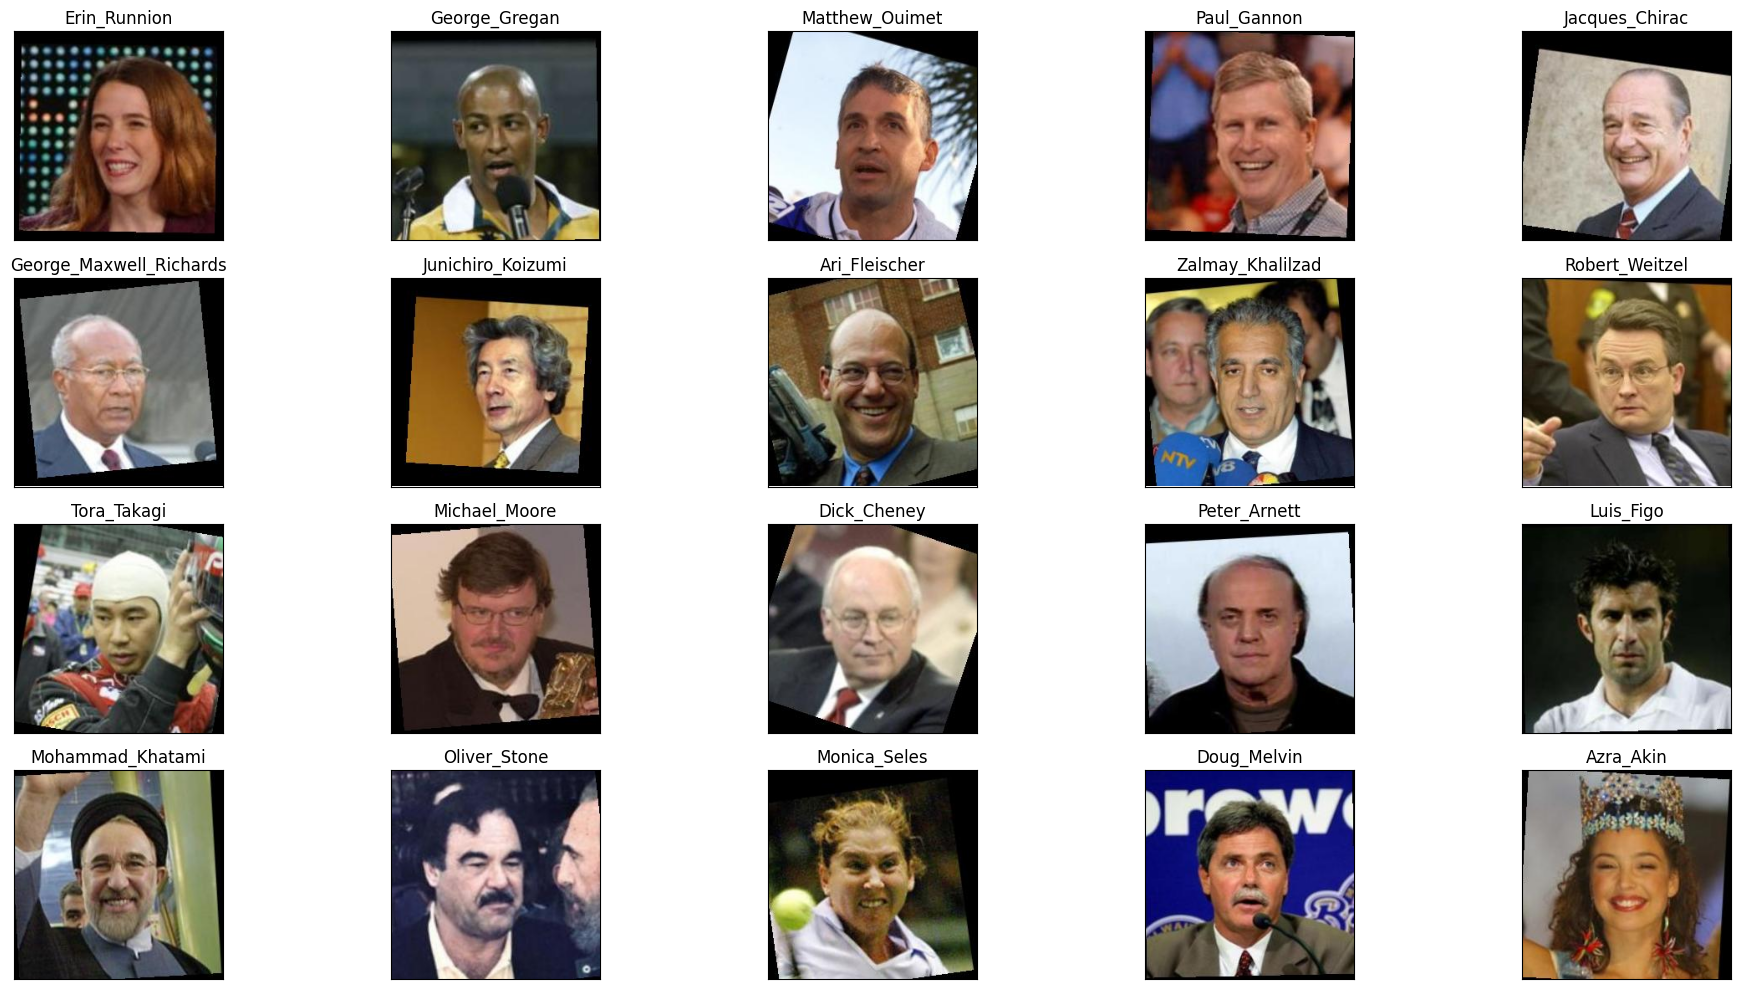

In [ ]:
sampled_id = []

plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
    sampled_id.append(idx)
plt.tight_layout()
plt.show()

The following cell shows the images with some of the background removed.

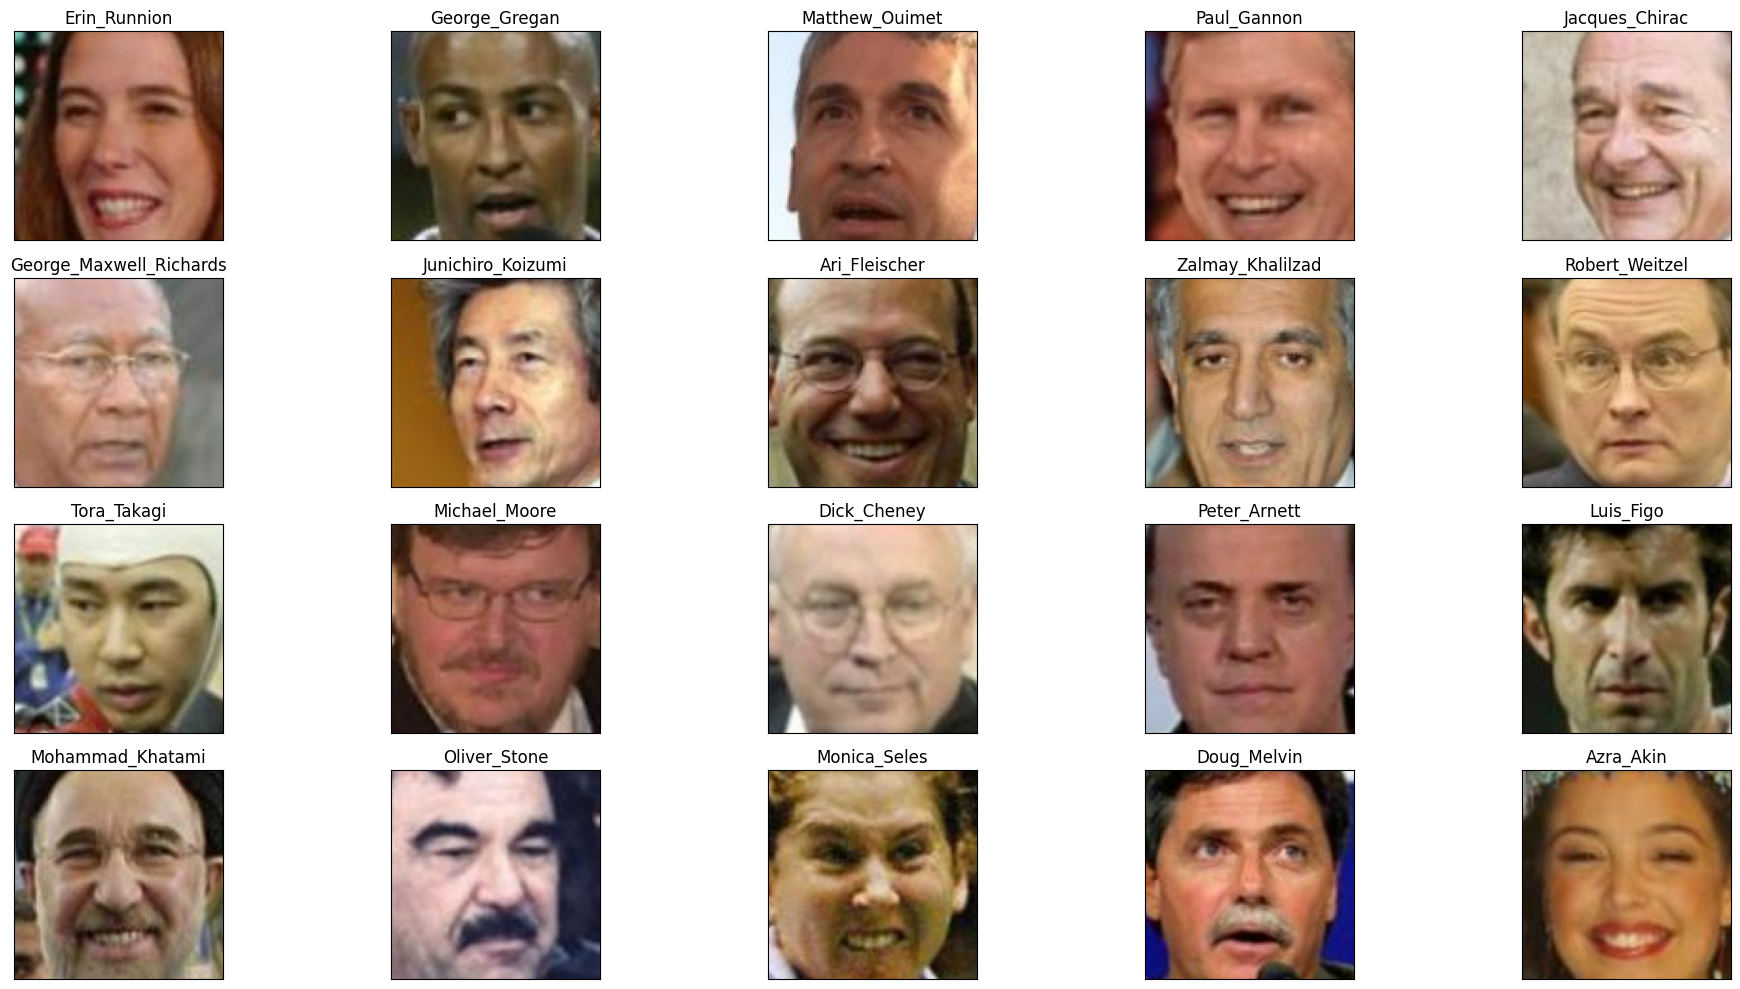

In [ ]:
dx=70
dy=70

plt.figure(figsize=(20,10))
for i in range(20):
    idx = sampled_id[i]
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img[dy:-dy,dx:-dx])
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The following function crops the images to 45x45 pixels, which is what we will use in this problem.

In [ ]:
def fetch_dataset(dx=70, dy=70, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

The variable `data` has all the face images and the variable `attrs` has all the attributes. The 8-bit RGB values are converted to values between 0 and 1 for modeling and plotting purposes.

In [ ]:
data, attrs = fetch_dataset()
data = np.array(data / 255, dtype='float32')

### Create Face Groups

We can now create groups of faces, by selecting the faces having the highest or lowest scores for each of the attributes. Run all the cells in this section to create and plot some face groups.

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.75 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

In [ ]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).head(36).index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(36).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(36).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(36).index.values
sunglasses_data = data[sunglasses_ids]

mustache_ids = attrs['Mustache'].sort_values(ascending=False).head(36).index.values
mustache_data = data[mustache_ids]

male_ids = attrs['Male'].sort_values(ascending=False).head(36).index.values
male_data = data[male_ids]

female_ids = attrs['Male'].sort_values(ascending=True).head(36).index.values
female_data = data[female_ids]

eyeclosed_ids = attrs['Eyes Open'].sort_values(ascending=True).head(36).index.values
eyeclosed_data = data[eyeclosed_ids]

mouthopen_ids = attrs['Mouth Wide Open'].sort_values(ascending=False).head(36).index.values
mouthopen_data = data[mouthopen_ids]

makeup_ids = attrs['Heavy Makeup'].sort_values(ascending=False).head(36).index.values
makeup_data = data[makeup_ids]

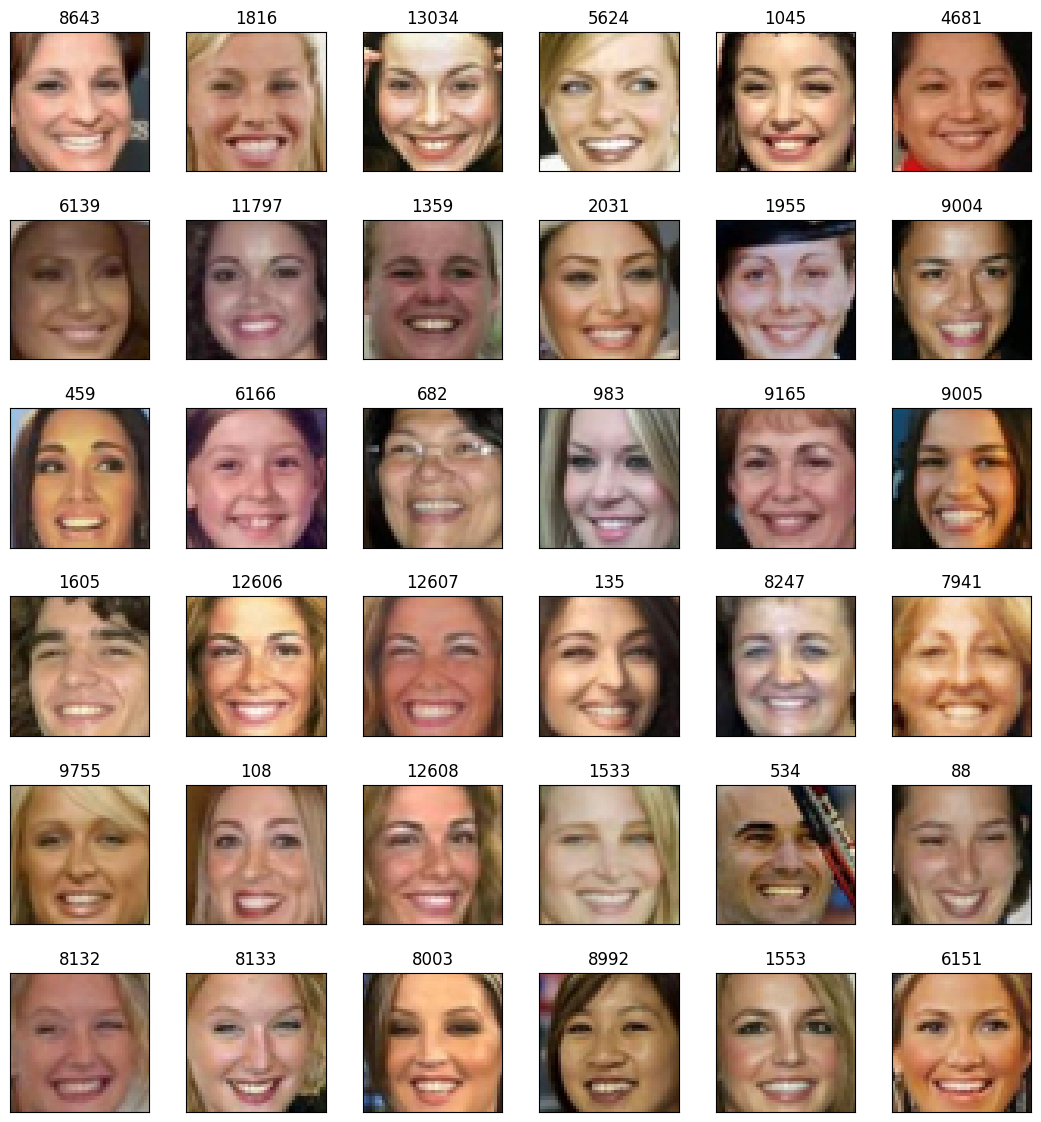

In [ ]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=smile_ids)

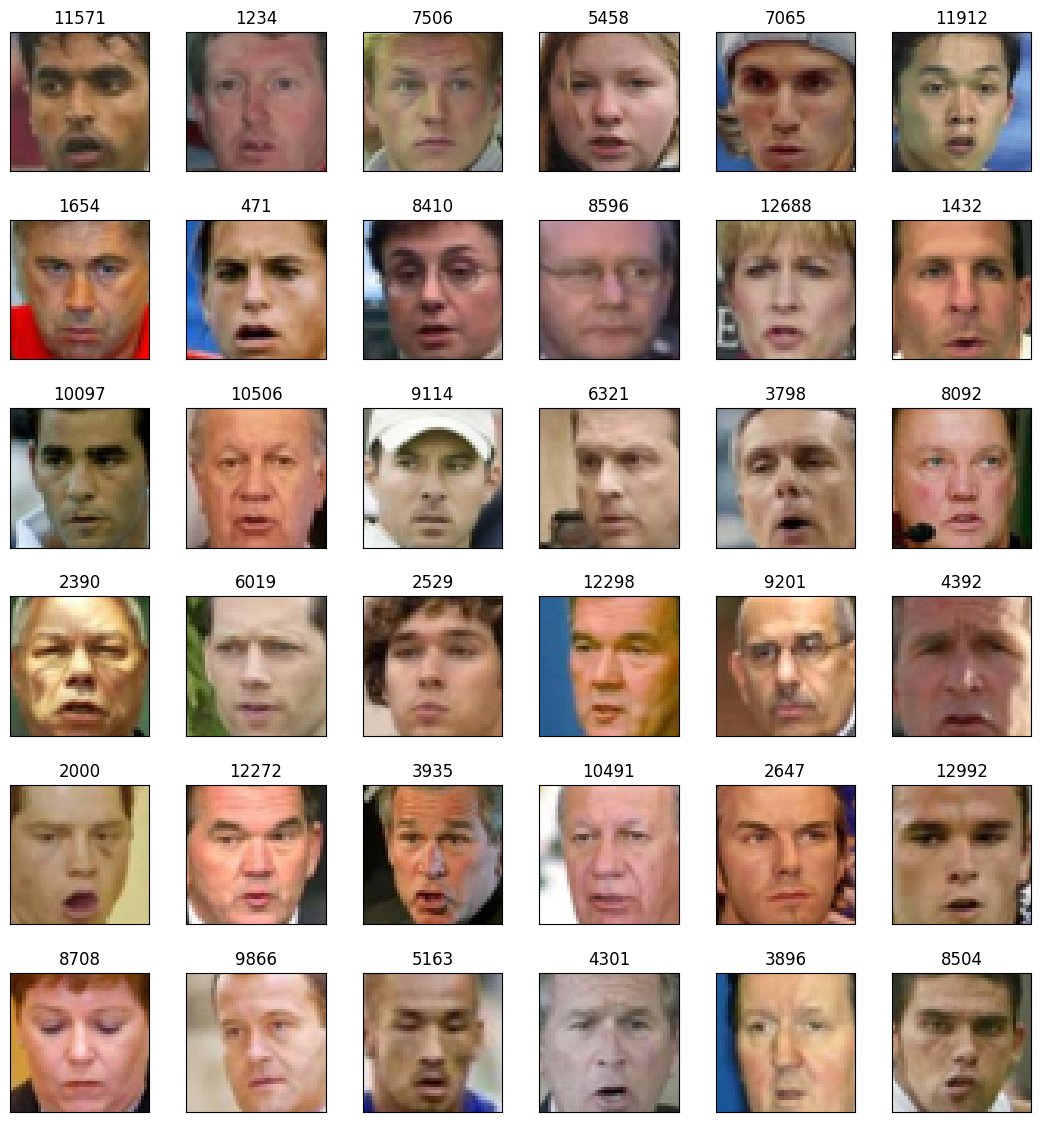

In [ ]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=no_smile_ids)

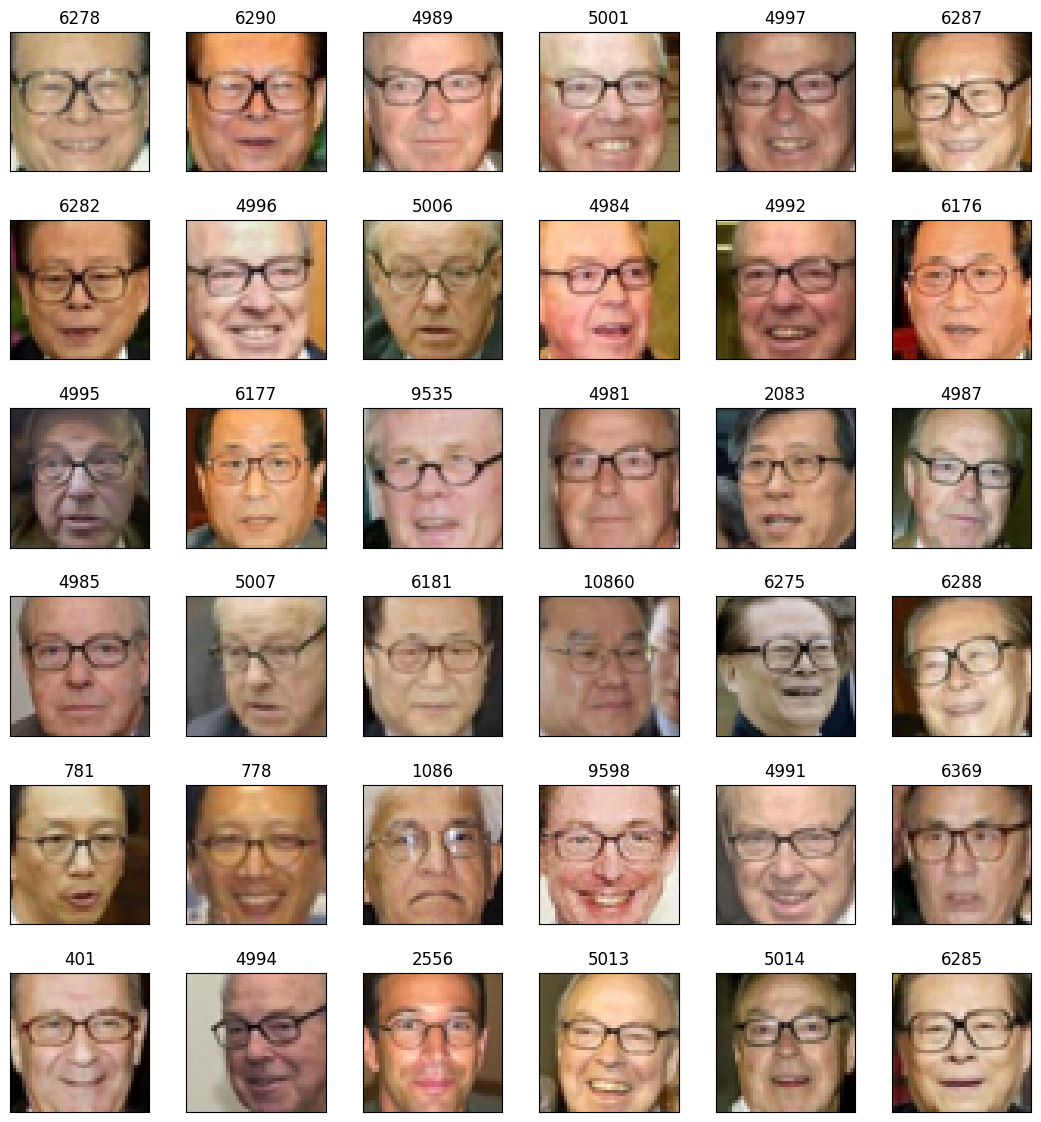

In [ ]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeglasses_ids)

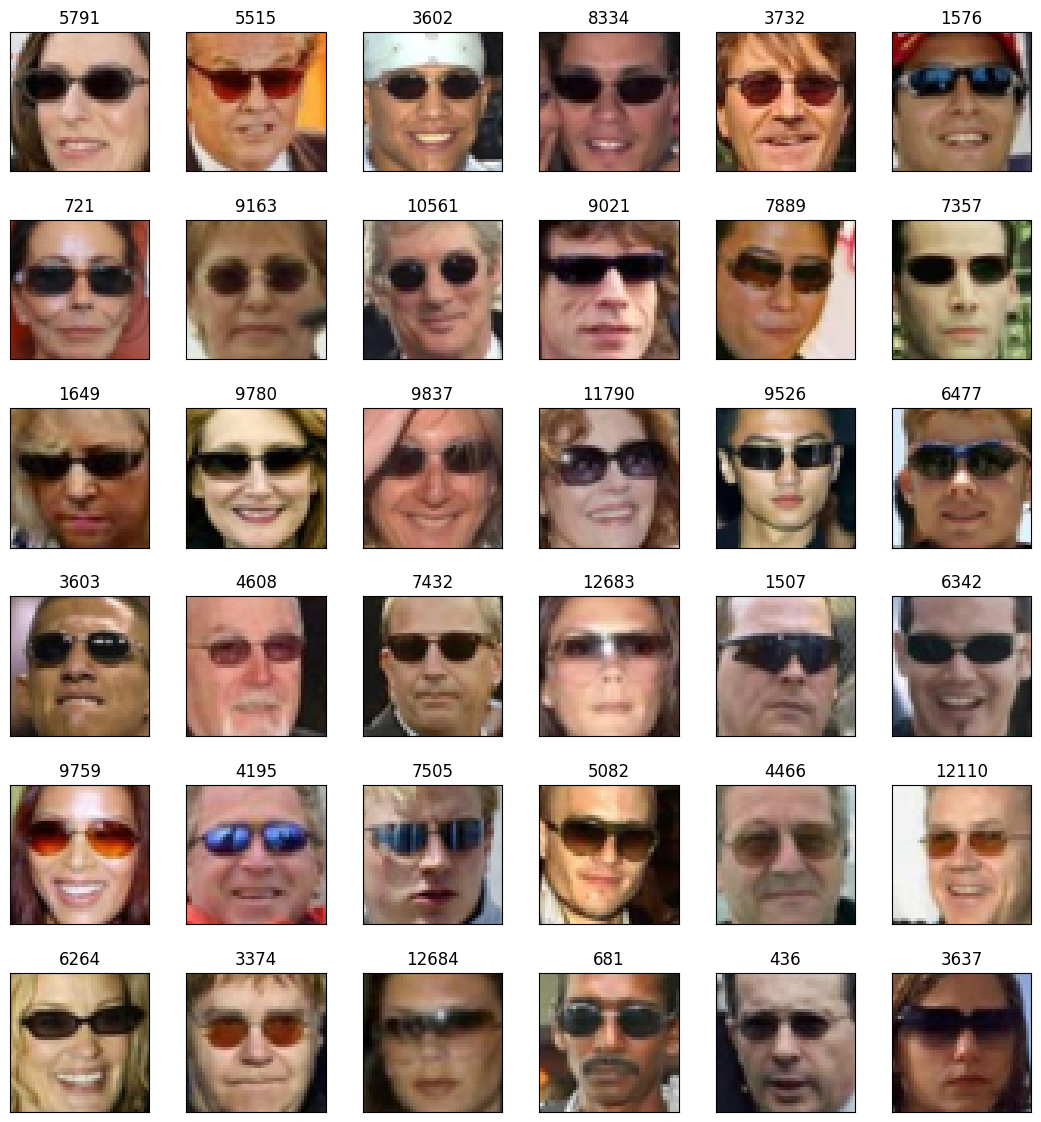

In [ ]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=sunglasses_ids)

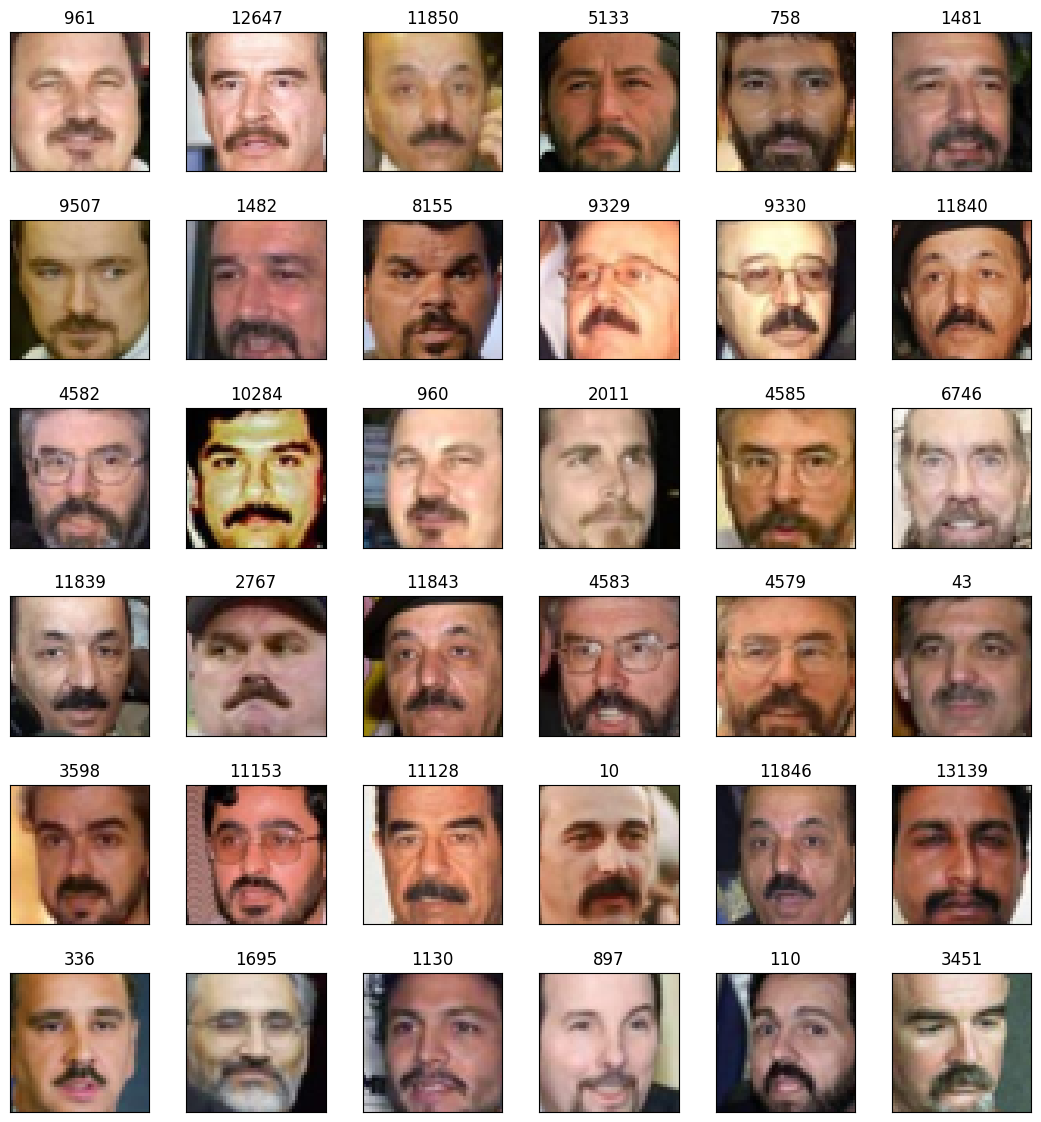

In [ ]:
plot_gallery(mustache_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mustache_ids)

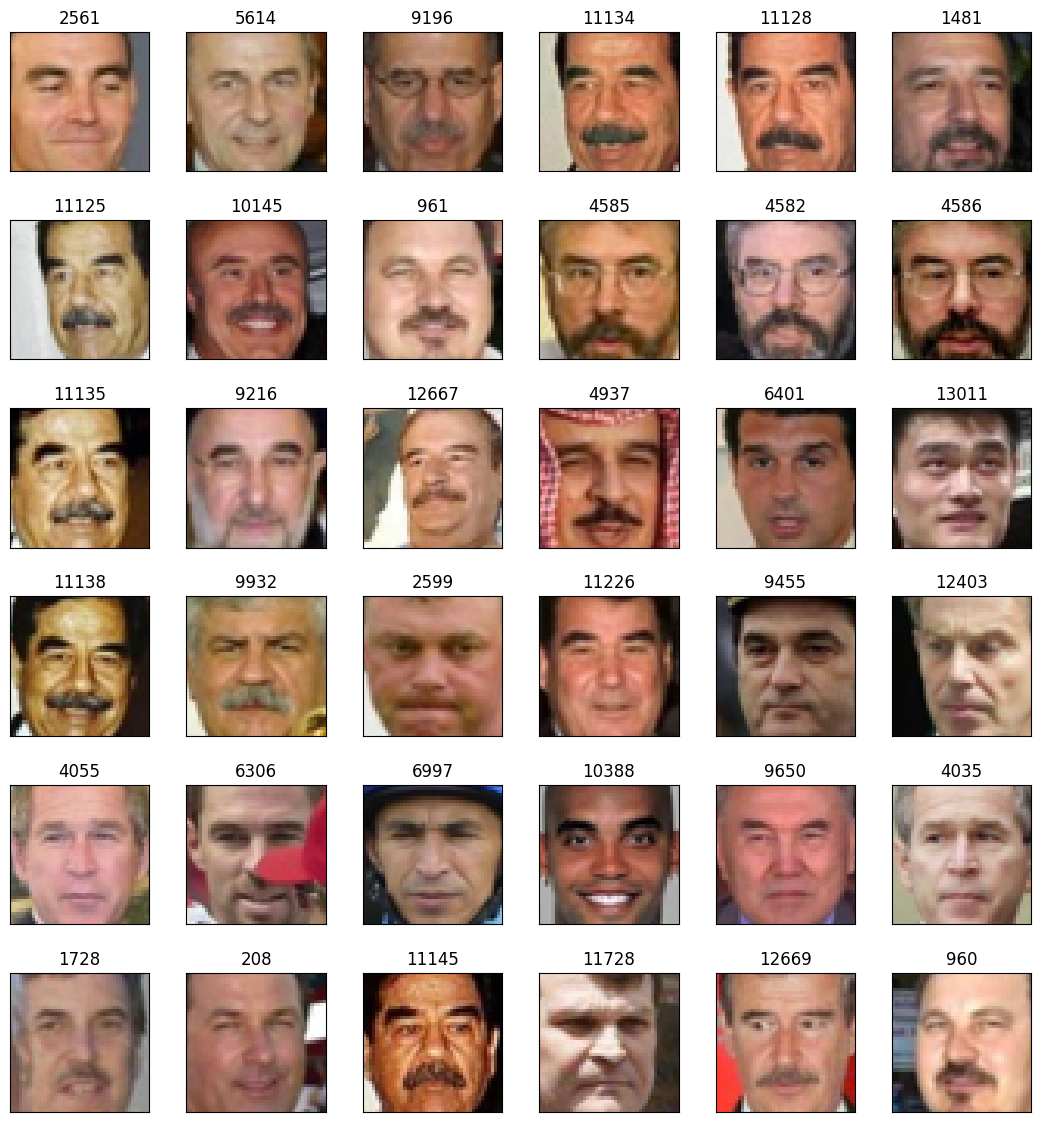

In [ ]:
plot_gallery(male_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=male_ids)

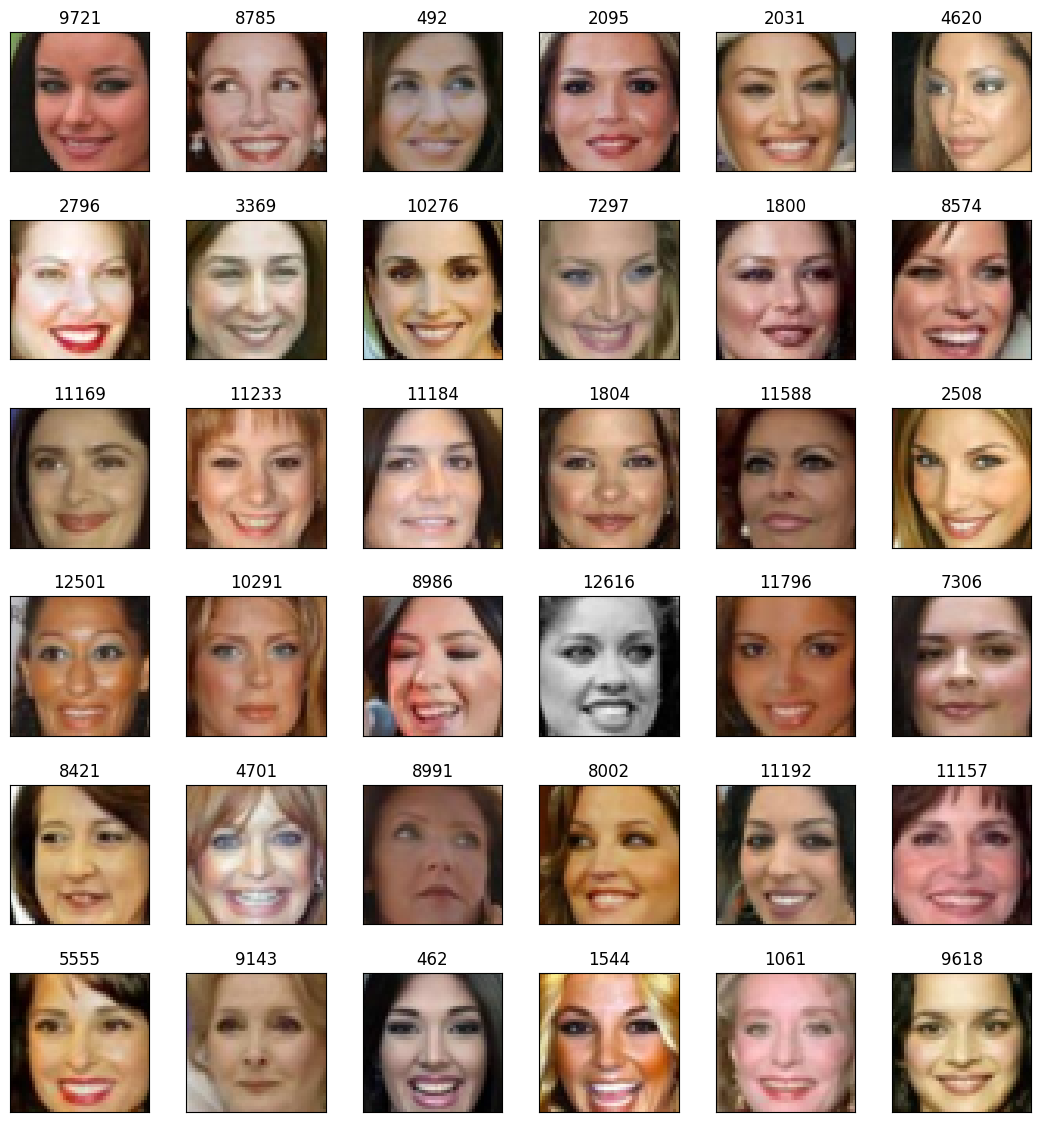

In [ ]:
plot_gallery(female_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=female_ids)

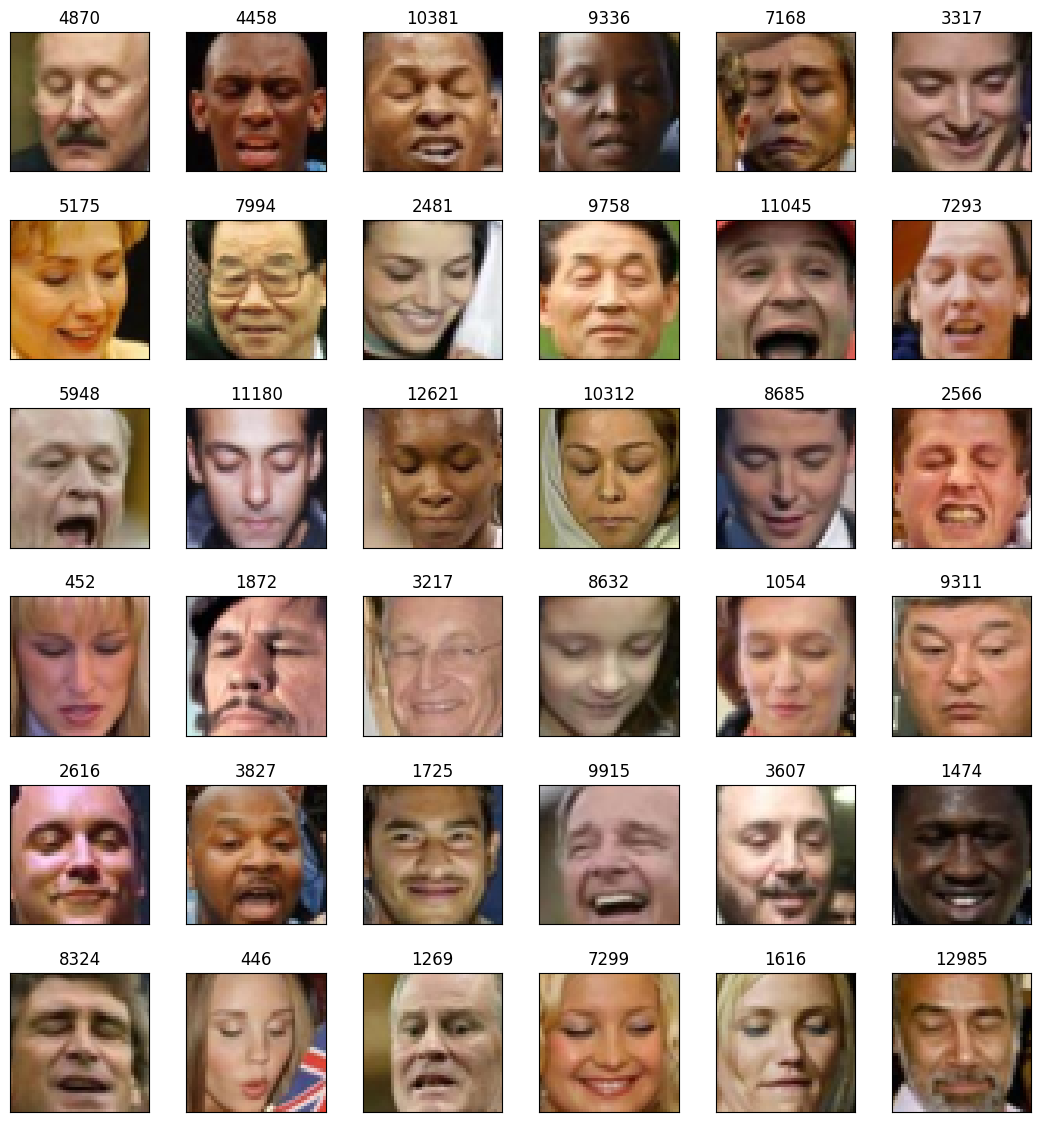

In [ ]:
plot_gallery(eyeclosed_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeclosed_ids)

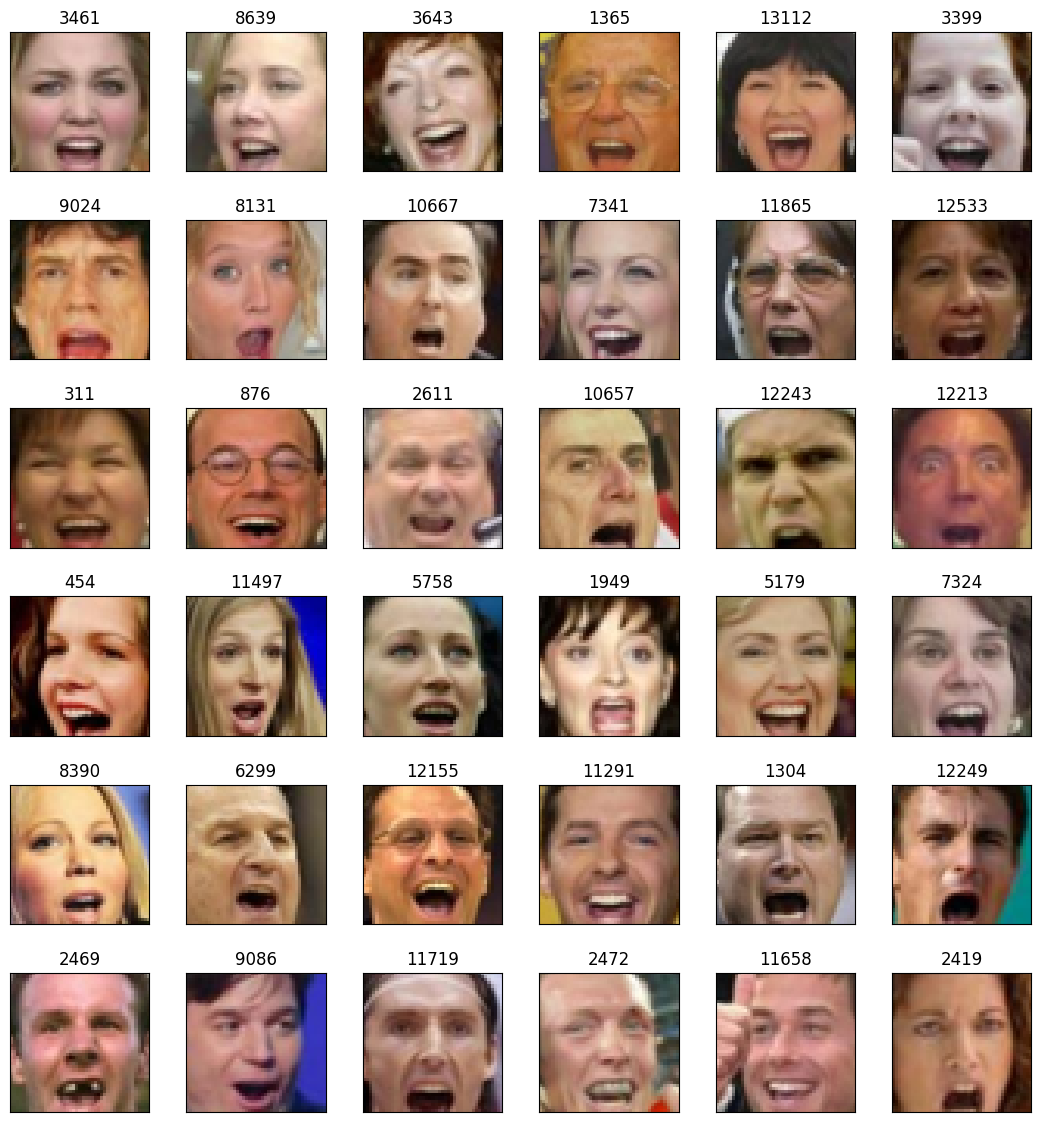

In [ ]:
plot_gallery(mouthopen_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mouthopen_ids)

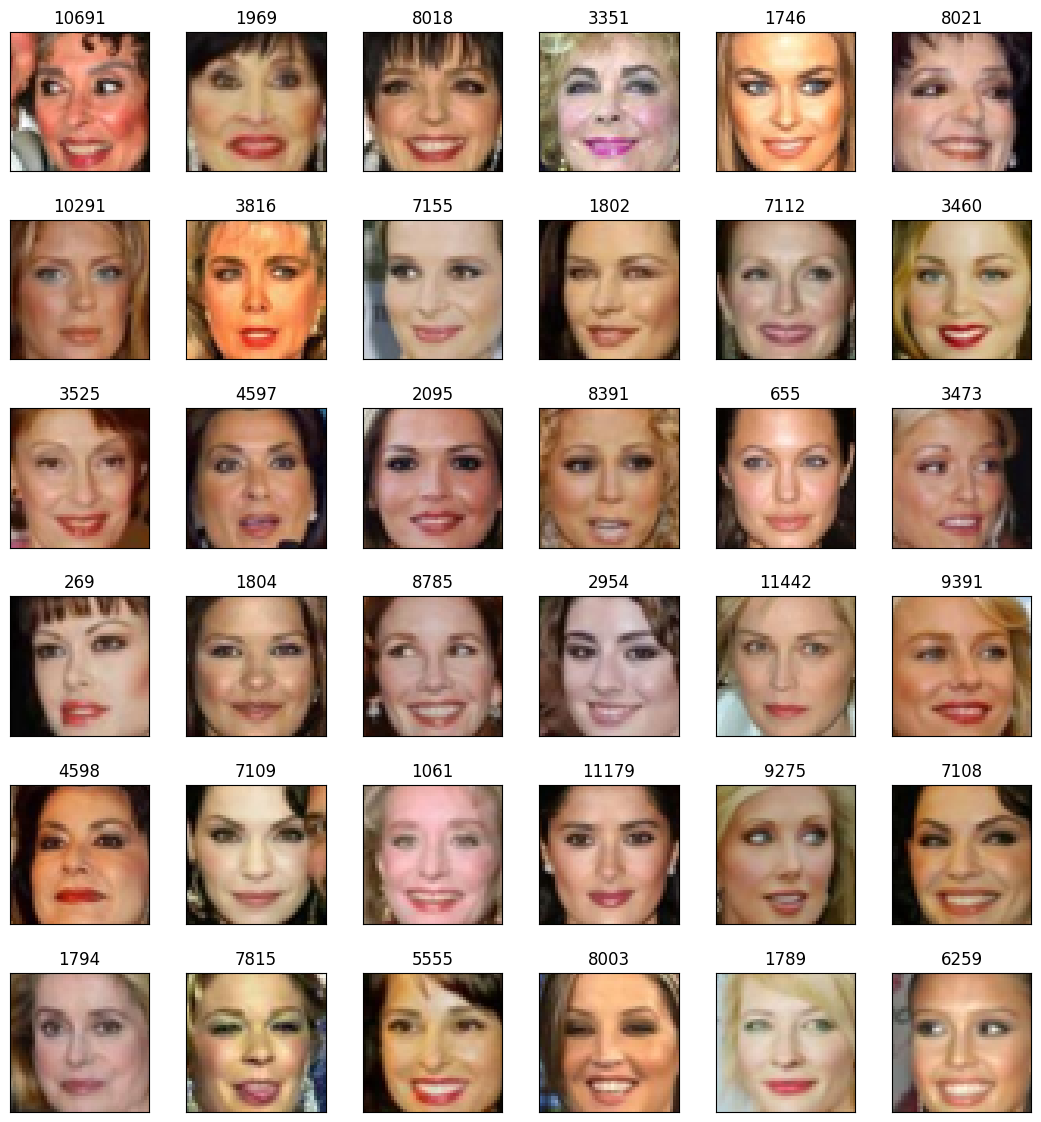

In [ ]:
plot_gallery(makeup_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=makeup_ids)

### Constructing the encoder

Recall that the encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [ ]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
input_data = tensorflow.keras.layers.Input(shape=(45, 45, 3))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 45, 45, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 41, 41,    │      4,864 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 18, 18,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 9, 9, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 32)  │     18,464 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 288)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 100)       │     28,900 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 100)       │     28,900 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ variational_mean… │
│                     │                   │            │ variational_log_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,056 (461.16 KB)

 Trainable params: 118,056 (461.16 KB)

 Non-trainable params: 0 (0.00 B)

### Construct the decoder

The decoder network in the VAE architecture maps a latent vector to an image.
This is done with a series of transposed convolutional layers, since it must
map from low to high dimensions.


In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(LATENT_SPACE_SIZE,))
decoder = tensorflow.keras.layers.Reshape((1, 1, 100))(decoder_input)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(32, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(16, (5,5), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(3, (6,6), activation='relu')(decoder)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 64)       │        57,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 32)       │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 20, 20, 16)     │        12,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 45, 45, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,675 (354.20 KB)

 Trainable params: 90,675 (354.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [ ]:
def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        return 0.5*reconstruction_loss_batch*factor

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [ ]:
from keras import ops, layers, Model
from keras.losses import mean_squared_error as mse

# --- KL layer ---
class KLLoss(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        # KL per sample: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
        kl_per_sample = -0.5 * ops.sum(1.0 + logvar - ops.square(mu) - ops.exp(logvar), axis=-1)
        self.add_loss(ops.mean(kl_per_sample))  # scalar KL
        return inputs  # pass-through

# 1) Create the KL node
kl_node = KLLoss(name="kl_loss")([distribution_mean, distribution_variance])

# 2) Tie the KL node into the forward graph but keep output = decoded
decoded = layers.Lambda(lambda xs: xs[0], name="with_kl")([decoded, kl_node])

# 3) (Re)build the model so the KL loss is included
autoencoder = tensorflow.keras.models.Model(input_data, decoded, name="autoencoder_with_kl")

# 4) reconstruction loss
def reconstruction_loss(y_true, y_pred, sum_over_channels=False):
    # per-pixel MSE (averaged over channels)
    per_pixel = mse(y_true, y_pred)                 # (B, H, W)
    H = ops.shape(per_pixel)[1]
    W = ops.shape(per_pixel)[2]
    factor = ops.cast(H * W, per_pixel.dtype)
    if sum_over_channels:
        C = ops.shape(y_true)[-1]                   # undo the channel mean
        factor = factor * ops.cast(C, per_pixel.dtype)
    return ops.mean(per_pixel) * factor             # mean over batch, sum over chosen dims

### 1.1 Deriving the loss function (5 points)

Derive the loss function defined in the cell above from the probability model perspective. You can ignore the scalar `factor` in your derivation. Show your work using either LaTeX or a picture of your written solution.

Hint: Think about how how the total loss is related to the ELBO.


**Model.**  
- Prior: $p(z)=\mathcal N(0,I)$.  
- Encoder (approx. posterior): $q_\phi(z\mid x)=\mathcal N\!\big(\mu_\phi(x),\operatorname{diag}(\sigma_\phi^2(x))\big)$, with $\text{logvar}=\log\sigma^2$.  
- Decoder / likelihood (Gaussian): $p_\theta(x\mid z)=\mathcal N\!\big(\hat x=f_\theta(z),\,\sigma^2 I\big)$.

**ELBO.**  
$$
\mathcal L_{\text{ELBO}}(x;\theta,\phi)
= \mathbb E_{q_\phi(z\mid x)}\!\big[\log p_\theta(x\mid z)\big]
- \mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right).
$$

Training minimizes the **negative ELBO**:
$$
\mathcal J(x)
= -\mathcal L_{\text{ELBO}}
= -\mathbb E_{q_\phi(z\mid x)}\!\big[\log p_\theta(x\mid z)\big]
+ \mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right).
$$

---

#### 1) Reconstruction term (negative expected log-likelihood)

With Gaussian likelihood $p_\theta(x\mid z)=\mathcal N(\hat x,\sigma^2 I)$,
$$
-\log p_\theta(x\mid z)
= \frac{1}{2\sigma^2}\,\lVert x-\hat x\rVert_2^2 + \text{const}.
$$

Taking expectation over $q_\phi(z\mid x)$ and dropping constants:
$$
-\mathbb E_{q_\phi}\!\big[\log p_\theta(x\mid z)\big]
\;\propto\;
\frac{1}{2\sigma^2}\,\mathbb E_{q_\phi}\!\left[\lVert x-\hat x\rVert_2^2\right]
\approx \tfrac{1}{2}\,\lVert x-\hat x\rVert_2^2,
$$
which is the **MSE** reconstruction

---

#### 2) KL term between diagonal Gaussians

For $q_\phi(z\mid x)=\mathcal N(\mu,\operatorname{diag}(\sigma^2))$ and $p(z)=\mathcal N(0,I)$,
$$
\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right)
= \frac{1}{2}\sum_{j=1}^d\Big(\mu_j^2 + \sigma_j^2 - 1 - \log\sigma_j^2\Big).
$$

Using $\text{logvar}=\log\sigma^2$ so that $\sigma^2=\exp(\text{logvar})$,
$$
\mathrm{KL}
= -\frac{1}{2}\sum_{j=1}^d
\Big(1 + \text{logvar}_j - \mu_j^2 - e^{\text{logvar}_j}\Big),
$$

---

### Final objective (negative ELBO)

Ignoring constants, the training loss minimized by the model is
$$
\boxed{
\mathcal J(x)
=
\underbrace{\tfrac{1}{2}\,\lVert x-\hat x\rVert_2^2}_{\text{reconstruction (MSE)}}
\;+\;
\underbrace{
-\tfrac{1}{2}\sum_{j=1}^d
\big(1 + \text{logvar}_j - \mu_j^2 - e^{\text{logvar}_j}\big)
}_{\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,\mathcal N(0,I)\right)}
}
$$


The following three cells train the model. You can just run them. It may take a while to run on your laptop.

In [ ]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=365)

In [ ]:
batch_size = 64
# autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100,
#                                   batch_size = batch_size), optimizer='adam')
autoencoder.compile(optimizer="adam", loss=reconstruction_loss)

autoencoder.summary()

Model: "autoencoder_with_kl"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 45, 45, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 41, 41,    │      4,864 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 18, 18,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 9, 9, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 32)  │     18,464 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 288)       │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 100)       │    118,056 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 100)       │     28,900 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 100)       │     28,900 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 45, 45, 3) │     90,675 │ functional[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_loss (KLLoss)    │ [(None, 100),     │          0 │ variational_mean… │
│                     │ (None, 100)]      │            │ variational_log_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ with_kl (Lambda)    │ (None, 45, 45, 3) │          0 │ functional_1[0][… │
│                     │                   │            │ kl_loss[0][0],    │
│                     │                   │            │ kl_loss[0][1]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 208,731 (815.36 KB)

 Trainable params: 208,731 (815.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val))

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 143.6666 - val_loss: 68.5268
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 66.1138 - val_loss: 58.9476
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 58.4817 - val_loss: 57.7865
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 55.1162 - val_loss: 51.6582
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 51.8827 - val_loss: 49.1359
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 49.8598 - val_loss: 48.3057
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 48.3008 - val_loss: 46.8526
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 47.0011 - val_loss: 46.1480
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 45.8469 - val_loss: 45.8633
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 45.5446 - val_loss: 45.2179
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 45.2093 - val_loss: 44.1879
Epoch 12/50
165/1

In [ ]:
autoencoder.save("Trained_VAE.tensorflow.keras")
encoder_model.save("Trained_Encoder.tensorflow.keras")
decoder_model.save("Trained_Decoder.tensorflow.keras")

If you experience issues while training the models above or if the process is taking too long, you may also use our pre-trained versions of the VAE, encoder, and decoder, which are available on Canvas.

No points will be taken off if you decide to use the pre-trained models, but we do recommend trying out the training process above. In case you encounter any issues when loading in the models, please post your questions on Ed discussion.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE = "/content/drive/MyDrive"  # they’re in “My Drive” per your screenshot

# sanity check: should list the three .h5 files
import os, glob
print("Found:", [os.path.basename(p) for p in glob.glob(f"{BASE}/*.h5")])


Mounted at /content/drive
Found: ['Trained_VAE.h5', 'Trained_encoder.h5', 'Trained_decoder.h5']


In [ ]:
import tensorflow as tf

custom_objects = {}
if 'sample_latent_features' in globals():
    custom_objects['sample_latent_features'] = globals()['sample_latent_features']
if 'KLLoss' in globals():
    custom_objects['KLLoss'] = globals()['KLLoss']


In [ ]:
ae = tf.keras.models.load_model(f"{BASE}/Trained_VAE.h5", compile=False, custom_objects=custom_objects)

enc = tf.keras.models.load_model(f"{BASE}/Trained_encoder.h5", compile=False, custom_objects=custom_objects)

dec = tf.keras.models.load_model(f"{BASE}/Trained_decoder.h5", compile=False, custom_objects=custom_objects)


### 1.2 Reconstructing faces (3 points)

The following cell encodes and reconstructs 16 random faces from the validation set with the trained VAE. Run the cell and comment on the reconstructed faces. (3 points)
* Do the reconstructed faces resemble the original images? How are they similar/different?
* Are there any faces that are reconstructed better or worse than the others? Can you think of why?
* Comment on any other aspects of your findings that are interesting to you.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


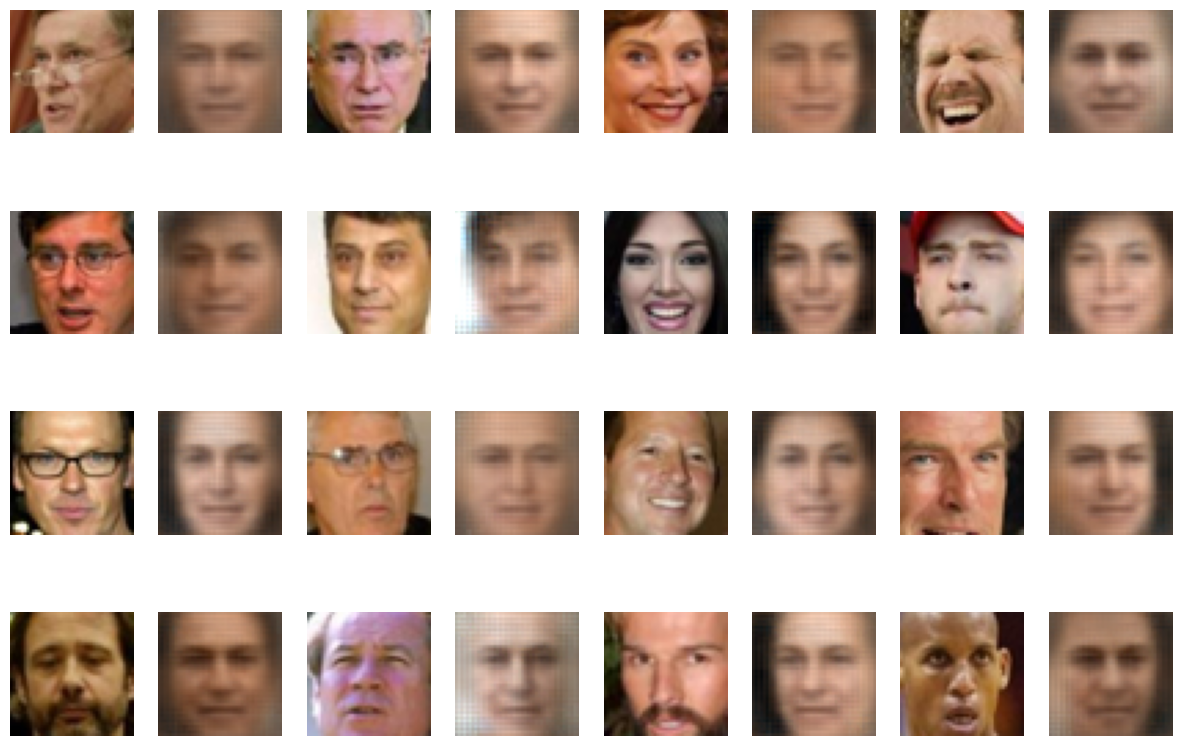

In [ ]:
sample_index = random.sample(range(1, len(X_val)), 16)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(X_val[sample_index[4*i+j], :, :, :])
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(np.clip(autoencoder.predict(np.array([X_val[sample_index[4*i+j], :, :, :]]))[0],0,1))
        axs[i, 2*j+1].axis('off')

1. Do the reconstructed faces resemble the original images? How are they similar/different?

**Answer:** Yes at a coarse level. The VAE preserves global structure: face location, rough head shape, pose (frontal vs slight turn), and broad colors (skin tone, hair color, background hue). Details are washed out. Eyes, teeth, hair strands, and skin texture are blurred; expressions look softer and less specific.

2. Are there any faces that are reconstructed better or worse than the others? Can you think of why?

**Better**: faces that are frontal, centered, evenly lit, and common in the dataset. These lie near high-density regions of the learned latent space, so the decoder can reproduce them more faithfully.

**Worse**: faces with unusual features (dark sunglasses, extreme lighting, strong shadows, saturated highlights, large pose variations). These are low-probability under the prior, so the model pulls them toward the “average face,” losing distinctive details.

3. Comment on any other aspects of your findings that are interesting to you.

**Comment:** There are multiple generated images that look similar to each other but the original picture is very different from each other.

### 1.3 Visualizing the latent space (10 points)

In `vae_demo` from class, the MNIST digits were generated from a two-dimensional latent space. In the current model, the latent space has more than two dimensions, so to visualize it we need to use a dimensionality reduction technique. (If you are not familiar with PCA, please refer to the material for Week 7 of [iML](https://ydata123.org/fa21/iml/calendar.html).)

In this problem, you will first implement the function `LatentSpace_2D`. (6 points)
1. Calculate the latent space encodings for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Use PCA to reduce the dimension of the latent space codes to two.
3. Visualize the latent space after dimensionality reduction with a scatter plot. Clearly color-code and label the two different groups.

Here is an example using smile_data and no_smile_data.
![Sample_1_3](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Sample_1_3.png)

Visualize the latent space for at least three pairs of face groups including smile vs. no smile. Comment on how the scatter plots look.
* Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)
* How do the plots for the three different attributes differ from each other? (2 points)

In [ ]:
def LatentSpace_2D(encoder_model, data1, label1, data2, label2):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    def _z_mean(enc_out):
        if isinstance(enc_out, (list, tuple)):
            return enc_out[0]
        return enc_out

    x1 = np.asarray(data1)
    x2 = np.asarray(data2)

    use_mean_layer = False
    try:
        mean_layer = encoder_model.get_layer('variational_mean')
        means_model = tf.keras.models.Model(
            inputs=encoder_model.input,
            outputs=mean_layer.output
        )
        use_mean_layer = True
    except Exception:
        means_model = None

    # Encode (batch)
    if use_mean_layer:
        # Directly read μ from the mean submodel
        latent1 = means_model.predict(x1, verbose=0)
        latent2 = means_model.predict(x2, verbose=0)
        z1, z2 = latent1, latent2
    else:
        z1 = _z_mean(encoder_model.predict(x1, verbose=0))
        z2 = _z_mean(encoder_model.predict(x2, verbose=0))

    # PCA
    Z = np.vstack([z1, z2])
    pca = PCA(n_components=2, random_state=0)
    Z2 = pca.fit_transform(Z)

    n1 = len(z1)
    Z1_2d, Z2_2d = Z2[:n1], Z2[n1:]

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(Z1_2d[:, 0], Z1_2d[:, 1], s=35, alpha=0.9, label=label1)
    plt.scatter(Z2_2d[:, 0], Z2_2d[:, 1], s=35, alpha=0.9, label=label2)
    plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.title(f"Latent space (PCA→2D): {label1} vs {label2}")
    plt.legend()
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.tight_layout()

    # Return projected points (and raw latents if we used the mean layer)
    if use_mean_layer:
        return Z1_2d, Z2_2d, latent1, latent2
    return Z1_2d, Z2_2d


(array([[-1.131473  ,  1.8374724 ],
        [ 0.97060084,  0.117466  ],
        [-1.1400863 ,  1.8248572 ],
        [ 0.21941659,  1.3048548 ],
        [-1.1162091 ,  0.8026329 ],
        [-0.8946672 ,  0.24466598],
        [-0.88068753, -1.7705662 ],
        [-1.4643654 , -0.24585237],
        [ 0.8563799 , -0.41550007],
        [-0.5492305 ,  0.6727011 ],
        [-1.2620375 , -1.4637829 ],
        [-2.0716643 ,  0.45627096],
        [-1.2788931 , -0.9847726 ],
        [-0.7537105 ,  1.0300984 ],
        [-1.445978  , -0.53312296],
        [ 0.12906742,  0.5626107 ],
        [-1.1018953 , -0.12045968],
        [-1.9292508 , -0.66722983],
        [-1.2975296 , -0.45329955],
        [-1.1694185 ,  1.148615  ],
        [-0.46011204, -0.49987632],
        [-0.9679109 ,  1.3150481 ],
        [-0.8744796 ,  1.3471092 ],
        [-0.1766104 ,  1.2459579 ],
        [ 0.38945308, -0.30629194],
        [-0.33808252,  0.16121933],
        [-0.77323514,  0.71260005],
        [ 0.3778345 ,  1.287

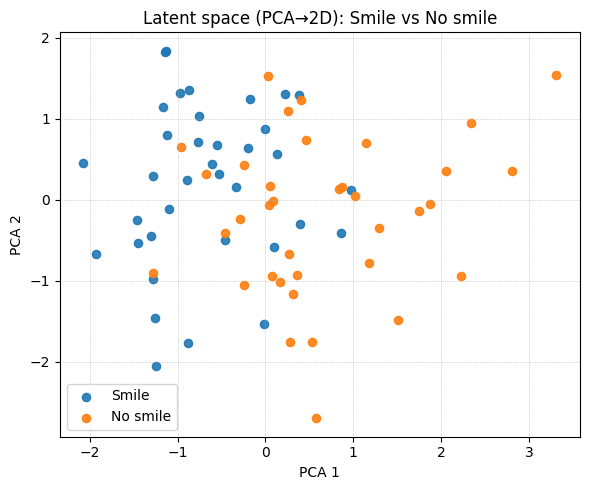

In [ ]:
LatentSpace_2D(encoder_model, smile_data, 'Smile', no_smile_data, 'No smile')

(array([[ 1.6681314 , -1.3144797 ],
        [ 0.15502541,  1.0801603 ],
        [ 1.7740307 , -1.3602166 ],
        [ 1.8824968 ,  0.2812499 ],
        [ 1.5682884 , -0.35025078],
        [ 0.96257967, -0.2174409 ],
        [-0.15759738,  1.0435084 ],
        [ 1.0865369 ,  0.15784663],
        [-1.0177583 ,  0.20038472],
        [ 0.6112601 , -0.36008257],
        [ 3.239173  ,  2.9122338 ],
        [ 1.3175439 , -1.2229232 ],
        [ 0.594617  ,  0.4685062 ],
        [ 1.801477  , -0.34362543],
        [ 1.949618  ,  1.5099689 ],
        [ 0.10696   , -0.7771741 ],
        [ 1.5543274 ,  0.7676626 ],
        [ 0.82072294, -0.25439426],
        [ 1.7316098 ,  1.4632306 ],
        [ 1.617825  , -0.9513689 ],
        [ 0.4244613 ,  0.55685705],
        [ 1.1366093 , -1.3207624 ],
        [ 1.8644137 , -0.5015376 ],
        [ 1.2960979 , -0.29496306],
        [-0.3113539 ,  0.46969625],
        [ 1.1766293 ,  0.62422633],
        [ 0.65589195, -0.57997054],
        [ 0.9659702 , -0.156

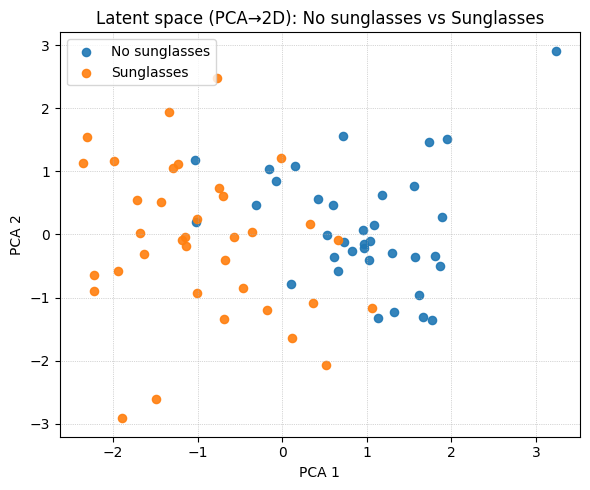

In [ ]:
LatentSpace_2D(encoder_model,smile_data,'No sunglasses',sunglasses_data,'Sunglasses')

(array([[ 0.57287383, -0.32603148],
        [-0.25614628,  0.50057113],
        [-0.4320246 , -0.6891501 ],
        [ 3.0236025 , -1.5680839 ],
        [ 3.5194077 , -1.5815346 ],
        [ 0.38623437,  0.21463111],
        [ 3.2927814 ,  0.00799036],
        [-1.0285319 , -0.9670356 ],
        [ 0.82481235,  0.72910786],
        [ 1.2872193 , -1.5169606 ],
        [-1.9271647 ,  0.18951422],
        [ 0.00723002, -0.83353335],
        [ 0.89721596,  1.685885  ],
        [ 0.32617694,  0.64696115],
        [ 1.0063226 , -0.28251234],
        [ 1.1465466 , -0.35345736],
        [ 2.309788  , -1.2036316 ],
        [-0.2754457 ,  0.63687754],
        [ 1.0179504 ,  0.16553527],
        [ 1.4012381 , -1.3401988 ],
        [ 1.4154081 , -1.7315878 ],
        [-0.6778362 , -0.22177516],
        [-1.5044461 , -1.1637336 ],
        [-2.5480876 , -1.2585042 ],
        [ 0.5654239 ,  0.6917014 ],
        [ 0.18656382,  0.29000953],
        [-1.7039744 , -0.71159506],
        [ 1.0752294 , -1.267

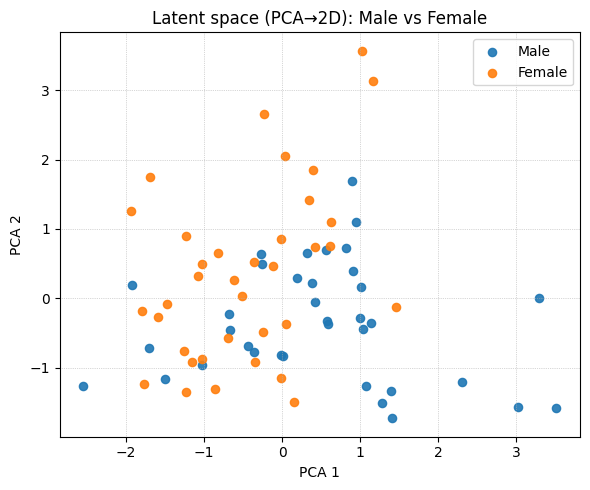

In [ ]:
LatentSpace_2D(encoder_model,male_data,'Male',female_data,'Female')

Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)

**Answer:**
The groups are not perfectly separable in 2-D, which is expected because the VAE is unsupervised and PCA compresses multi-dimensional factors into two axes.

How do the plots for the three different attributes differ from each other? (2 points)

**Answer:**
Sunglasses separate best due to a strong, localized pixel change that the VAE captures in a consistent latent direction. Smile separates moderately as a continuous expression intensity; clusters partially overlap. Female vs. male shows the most overlap because the signal is diffuse and confounded, so its not isolated in a single 2-D projection.

### 1.4 Morphing between faces (4 points)

Morph at least 5 pairs of faces with the function `morphBetweenImages` and comment on what you observe.
* Briefly explain how the morphing works. (2 points)
* Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

In [ ]:
# Don't change the function
def morphBetweenImages(img1, img2, num_of_morphs):
    alpha = np.linspace(0,1,num_of_morphs)
    z1 = encoder_model.predict(np.array([img1]))
    z2 = encoder_model.predict(np.array([img2]))
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)

    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = decoder_model.predict(z)

        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(np.clip(new_img.squeeze(),0,1))
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))

    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


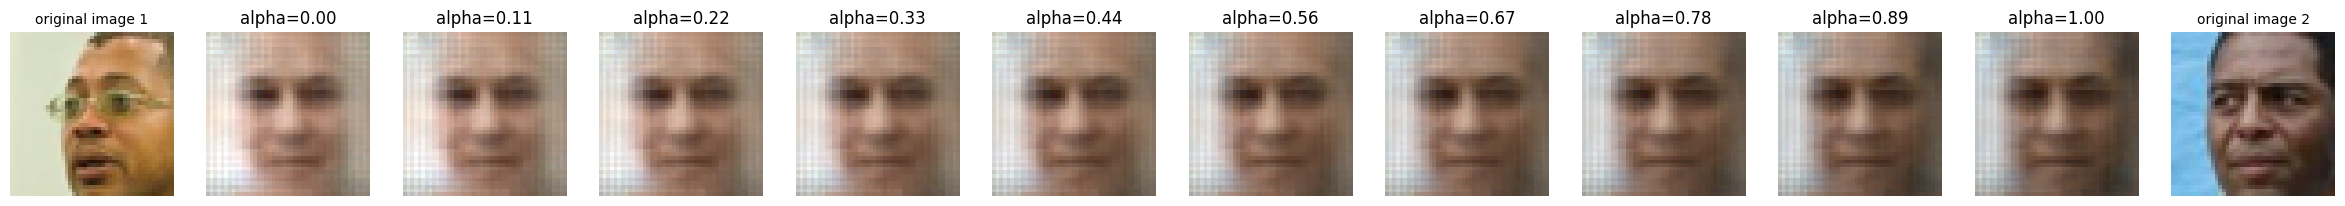

In [ ]:
sample_index = random.sample(range(1, len(data)), 2)
morphBetweenImages(data[sample_index[0]],data[sample_index[1]],10)

Briefly explain how the morphing works. (2 points)

**Answer:** We linearly interpolate 2D facial landmarks to get an intermediate shape at each  t, build a Delaunay triangulation on that shape, piecewise-affine warp both source images into the intermediate geometry, and then linearly cross-dissolve the two warped images.

Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

**Answer:**
Yes. The results looked roughly as expected but behaved mostly like a soft cross-dissolve with a blurry “average face” mid-morph; the example pair (opposite head turns + glasses in one) showed ghosting and worked worse. Pairs that worked best were frontal, neutral-expression, similarly lit and framed faces

### 1.5 Attribute shift (10 points)

In 1.3, we've seen that faces with the same attributes form clusters in the latent space. In this problem, you will implement a function `AttributeShift` to change one attribute of the faces.

First implement the function `AttributeShift`. (5 points)
1. Calculate the latent space codes for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Calculate the mean latent space code for each group.
3. Get the attribute shifting vector by taking the difference between the two codes.
4. Perform attribute shift by adding the attribute shifting vector to the latent space code of the faces you want to modify.
5. Generate the image using the new latent space codes.

Here is a diagram demonstrating the shift in the latent space. Please note that the two-dimensional latent space is just for demonstration purpose. You should *not* use PCA in this problem. Instead, use the original latent space.
![Diagram_1_5](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Diagram_1_5.png)

Perform attribute shift on at three attributes including smile. Comment on the faces with shifted attributes. (5 points)
* Do the generated faces look like what you expected? If not, can you think of some possible reasons?
* Do the faces with new attributes resemble the original faces? If not, can you think of some possible reasons?
* Which of the attribute shift is more successful? What are some possible reasons?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
# Don't change this helper function!
def PlotAttributeShift(data2,pic_output):
    sample_index = random.sample(range(1, len(data2)), 16)

    fig, axs = plt.subplots(4, 8)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data2[sample_index[4*i+j], :, :, :])
            axs[i, 2*j].axis('off')
            axs[i, 2*j+1].imshow(np.clip(pic_output[sample_index[4*i+j]],0,1))
            axs[i, 2*j+1].axis('off')

In [ ]:
def AttributeShift(encoder_model, decoder_model, data1, data2):
    # Encode both groups to latent space
    latent1 = encoder_model.predict(data1)
    latent2 = encoder_model.predict(data2)
    # Compute mean latent vectors for each group
    mean1 = np.mean(latent1, axis=0)
    mean2 = np.mean(latent2, axis=0)
    # Calculate the attribute shift vector (from group2 to group1)
    shift_vector = mean1 - mean2
    # Apply the shift to the latent codes of data2 and decode to images
    new_latent = latent2 + shift_vector
    pic_output = decoder_model.predict(new_latent)
    return pic_output


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step


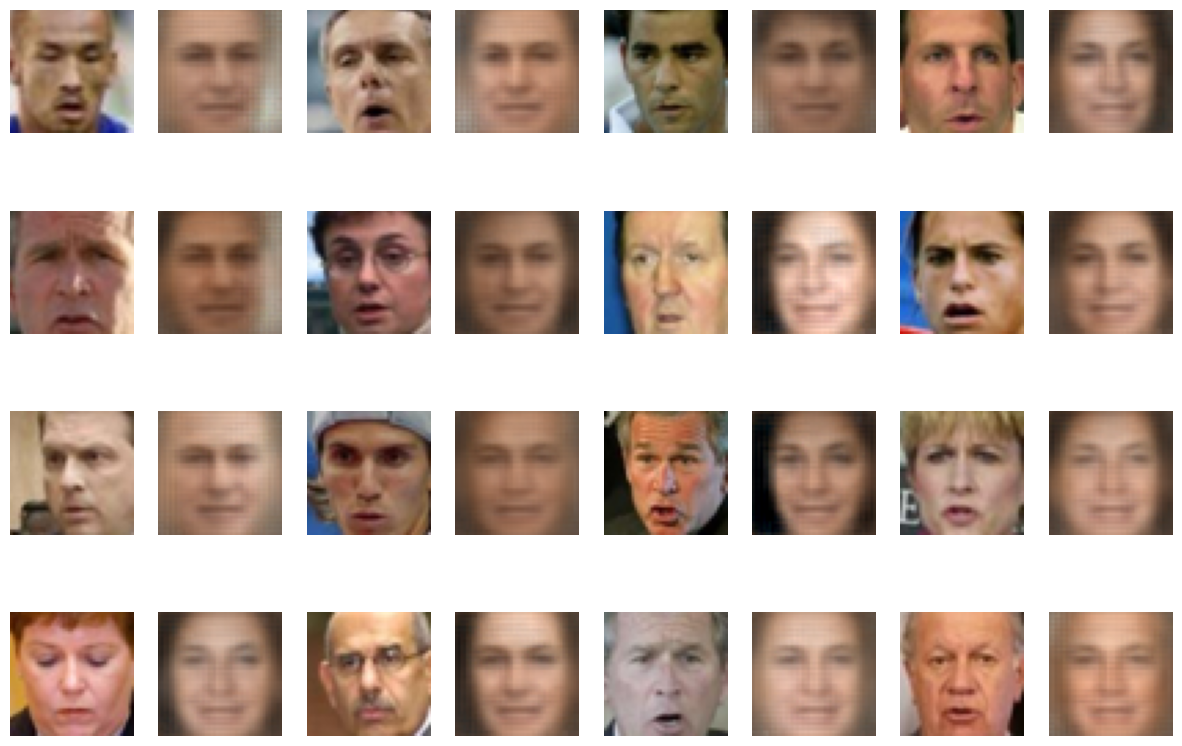

In [ ]:
pic_output = AttributeShift(encoder_model,decoder_model,smile_data,no_smile_data)
PlotAttributeShift(no_smile_data,pic_output)

1. Do the generated faces look like what you expected? If not, can you think of some possible reasons?

**Answer:** Not really. Many shifted results collapse toward the same blurry, smiley “average face.” That's classic when a single linear shift pushes codes off-manifold and the decoder falls back to a mean-ish look. It also happens if the attribute vector is dominated by one subgroup (e.g., female+smile examples), so everything moves toward that prototype.


2. Do the faces with new attributes resemble the original faces? If not, can you think of some possible reasons?

**Answer:** Only weakly. Identity cues (bone structure, moles, wrinkles) are washed out; some faces even change apparent sex/age. Some causes might be entangled latent space (smile is correlated with gender/hair in training data), too-large step in latent space, class imbalance / noisy means, and slight pre/post-processing mismatch (decoder saturation to blur).

3. Which of the attribute shift is more successful? What are some possible reasons?

**Answer:** Smile worked the best (you can see mouth corners/cheek lines appear). Sunglasses was worse (occlusion + specular highlights are hard and not linear). Gender was worst: it triggers big, global changes (hairline, skin smoothing), so a single vector over-edits and breaks identity.

4. Comment on any other aspects of your findings that are interesting to you.

**Answer:** When the model “adds” an attribute (like a smile), it doesn't paint pixels directly—it tweaks a few latent features that nudge mouth corners, cheeks, and eyes together, so multiple small geometric/texture changes appear at once

### 1.6 Generating new faces (3 points)

Variational autoencoders can be used to generate new data; this is why they are generative models. We can sample new data points from the distribution in latent space and reconstruct new, fake faces based on them.

To draw a sample close to an existing sample in the latent space, we can add a scaled random sample from the normal distribution to the latent space code of an existing sample. The scalar, which we call the `noise_level` is a parameter that we can tune.

Run `GenerateFaces` with three different values of `noise_level` and comment on the generated faces. (3 points)
* Do the generated images look like faces?
* What happens when the new samples diverge more from the existing samples? What is a possible reason?

In [ ]:
def GenerateFaces(data, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(data)), 15)
    latent_space = noise_level * np.random.normal(size=(15, LATENT_SPACE_SIZE)) \
                   + encoder_model.predict(data[sample_index])
    generated_image = decoder_model.predict(latent_space)
    fig = plt.figure(figsize=(15, 10))
    number_of_images = len(sample_index)  # ensure this is defined (typically 15)
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.imshow(np.clip(generated_image[i], 0, 1))
        ax.axis('off')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


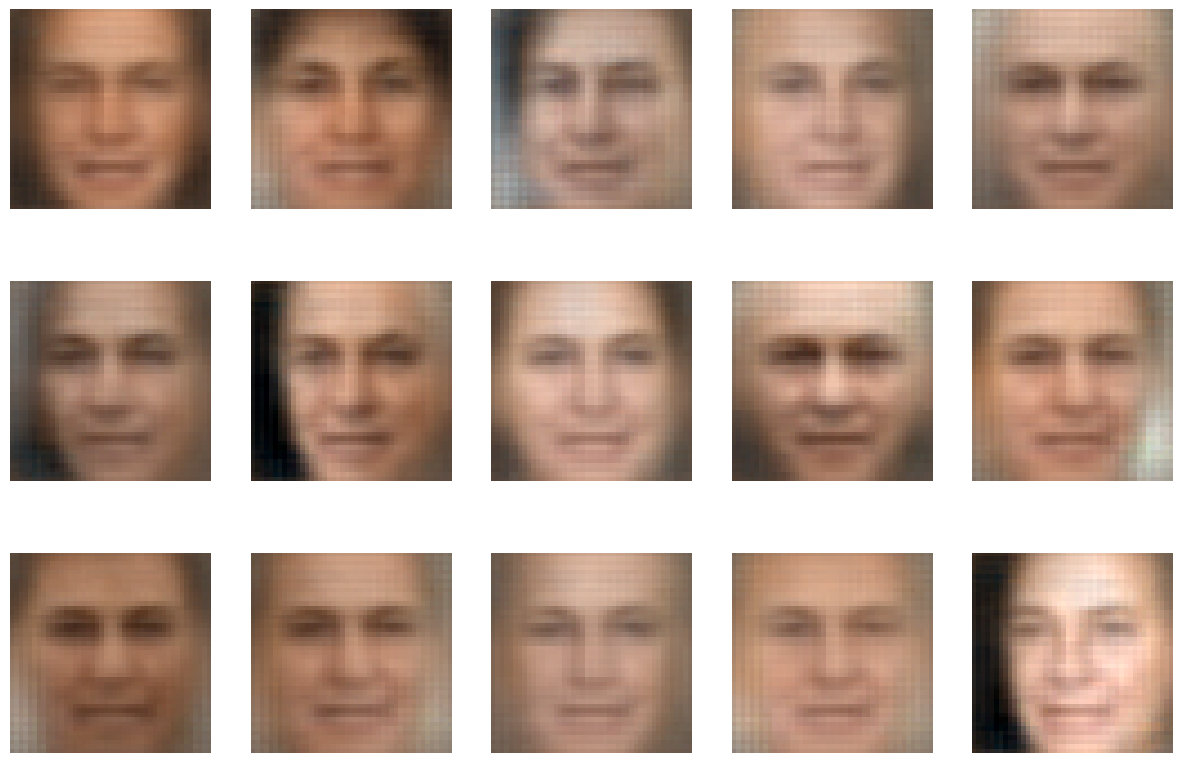

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.001)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


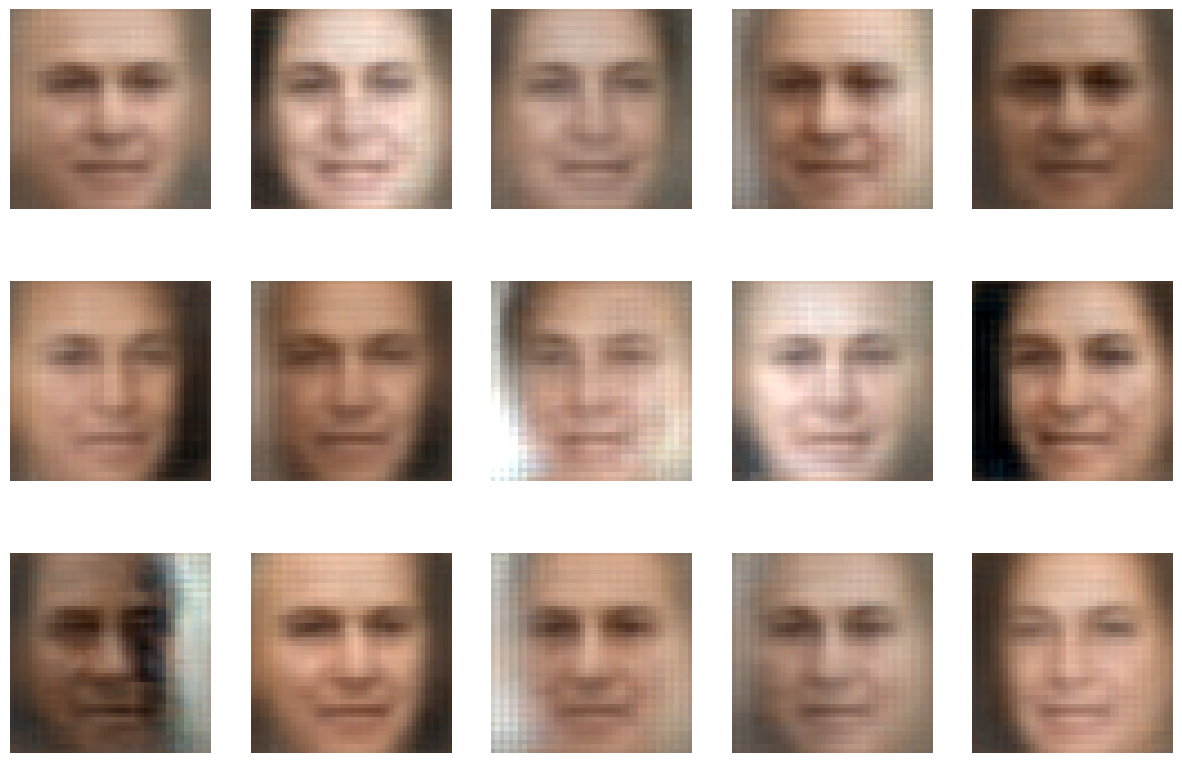

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


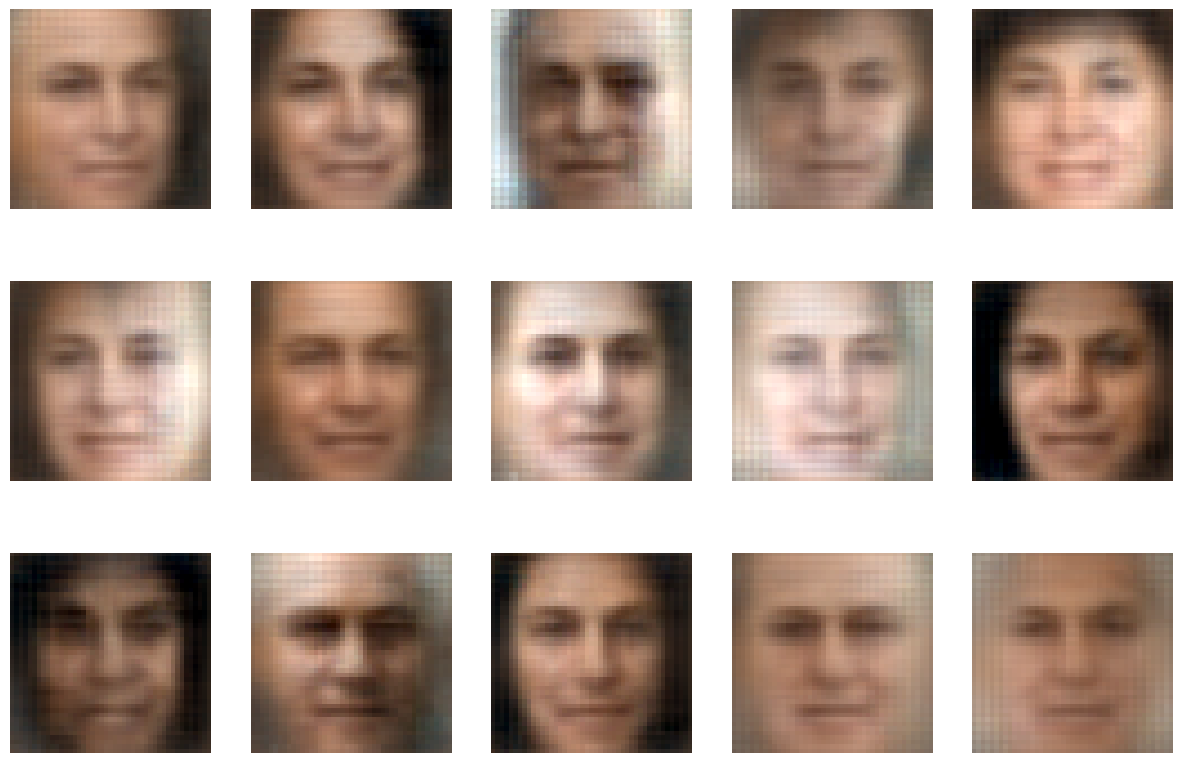

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,1)

1. Do the generated images look like faces?

Noise_level = 0.001 (I changed it to see it more clearly): Yes, images look like clear faces and stay close to the original identity (only small changes in expression/lighting). Sharpest results.

Noise_level = 0.5: Mostly still faces, but identity starts to drift; more variety (hair/pose/skin tone shift) and a bit more blur. Realism went down slightly, and become more indistinguishable.

Noise_level = 1.0: Several samples no longer look convincingly human—features smear or become generic “average” faces. Some outputs show artifacts or odd textures.

2. What happens when the new samples diverge more from the existing samples? What is a possible reason?

As noise increases, we move farther from the original code and can leave the data manifold learned by the VAE. The decoder then receives latent points it didn't see during training and “hallucinates” blurry/unstable images. (VAEs use a simple N(0,1) prior, but the true posterior manifold is not perfectly spherical) Thus there's a realism vs diversity trade-off: small noise preserves identity and quality; large noise gives variety but degrades fidelity.

### Optional: Changing the loss function (2 points extra credit)

The variable `factor` is a parameter of the loss function. In this optional problem, you will play with it and think about its effect on the performance of VAE.

Retrain the model with a smaller factor. Repeat 1.2, 1.6 (using `noise_level` = 1) and latent space visualization. Comment on how the reconstruction results, generated new faces and latent space distributions change. (2 points)
* Which model reconstructs the faces better?
* Do the generated faces look different?
* How do the latent variable distributions differ?
* Do the differences make sense? Can you explain what you observed?

In [ ]:
small_factor = 1  # smaller than the default 100 used earlier
batch_size = 64

mean_t   = autoencoder.get_layer('variational_mean').output
logvar_t = autoencoder.get_layer('variational_log_variance').output

autoencoder.compile(optimizer='adam',
                    loss=get_loss(mean_t, logvar_t, factor=small_factor, batch_size=batch_size))

history_small = autoencoder.fit(X_train, X_train,
                                epochs=10, batch_size=batch_size,
                                validation_data=(X_val, X_val), verbose=1)

# 1.2 (repeat): Show reconstructions on validation set
sample_index = random.sample(range(1, len(X_val)), 16)
fig, axs = plt.subplots(4, 8, figsize=(15,10))
for i in range(4):
    for j in range(4):
        idx = sample_index[4*i+j]
        axs[i, 2*j].imshow(X_val[idx]); axs[i, 2*j].axis('off')
        rec = np.clip(autoencoder.predict(np.array([X_val[idx]]), verbose=0)[0], 0, 1)
        axs[i, 2*j+1].imshow(rec); axs[i, 2*j+1].axis('off')
plt.suptitle(f"1.2 Reconstructions after smaller factor={small_factor}")
plt.show()

# 1.6 (repeat): Generate new faces, noise_level=1
GenerateFaces(data, LATENT_SPACE_SIZE, noise_level=1.0)

# 1.3 (repeat): Latent space viz for three attributes
LatentSpace_2D(encoder_model, smile_data, "Smile", no_smile_data, "No smile")
LatentSpace_2D(encoder_model, no_sunglasses_data, "No sunglasses", sunglasses_data, "Sunglasses")
LatentSpace_2D(encoder_model, female_data, "Female", male_data, "Male")


1. Which model reconstructs the faces better?

**Answer:** The original (larger-factor) model. Reconstructions are sharper and preserve fine details (hair strands, eyeglass rims, mouth corners) because the loss leans harder on pixel accuracy.

2. Do the generated faces look different?

**Answer:** With a smaller factor, samples at noise_level = 1 look more diverse but softer/blurrier. With the larger factor, generations are sharper when you perturb real encodings slightly, but they can show more artifacts when you push farther from seen data.

3. How do the latent variable distributions differ?

**Answer:**
Smaller factor means codes are tighter and more isotropic around 0 (closer to N(0, I)); attribute groups (smile/no-smile, sunglasses/no, female/male) overlap more in the 2D PCA.

Larger factor means codes are more spread and structured, so those groups are more separable in 2D plots.

4. Do the differences make sense? Can you explain what you observed?

**Answer:** Yes. Lowering factor increases the relative weight of the KL term in the ELBO, pushing q𝜙(z|x) toward the unit-Gaussian prior. That regularizes/smooths the latent space (good for diversity and sampling) but trades off reconstruction fidelity, hence blurrier images and more overlap in latent 2D. A larger factor relaxes that pressure, letting the model encode more detail (better recon), at the cost of a less-Gaussian latent (worse global sampling, stronger attribute separation in PCA).

## Problem 2: Gaussian neighborhood regression (10 points)
In multivariate Gaussians, edges are about *direct* relationships after controlling for all other variables. The conditional law of a single coordinate $X_i$ given the rest $X_{-i}$ reveals which variables directly “enter” the model for $X_i$. Algebraically, this local behavior is encoded by the $i$th row/column of the precision matrix $\Omega=\Sigma^{-1}$.  Graphical Lasso estimates a sparse precision matrix $\widehat{\Omega}$ by maximizing the Gaussian log-likelihood with an $\ell_1$ penalty on off-diagonal entries. Zeros in $\widehat{\Omega}$ correspond to missing edges (conditional independences) in the learned graph.



Let $X=(X_1,\dots,X_p)^\top \sim \mathcal N_p(0,\Sigma)$, and write $\Omega=\Sigma^{-1}$. For $i\in\{1,\dots,p\}$, denote $-i=\{1,\dots,p\}\setminus\{i\}$.




### 2.1 Conditional law of one node.
Show that $X_i\mid X_{-i}$ is Gaussian with a linear mean in $X_{-i}$. Express the regression coefficients $\beta_{i\leftarrow -i}\in\mathbb{R}^{p-1}$ and the conditional variance $\sigma^2_{i\mid -i}$ in terms of $\Omega$.


*Hint.* You may *complete the square* on $x^\top\Omega x$, or use a *Schur complement* derivation. After permuting coordinates so that $i$ is first, partition
$$
\Sigma \;=\; \begin{bmatrix}
a & b^\top \\[4pt]
b & C
\end{bmatrix},
\quad
a=\Sigma_{ii}\in\mathbb{R},\; b=\Sigma_{-i,i}\in\mathbb{R}^{p-1},\; C=\Sigma_{-i,-i}\in\mathbb{R}^{(p-1)\times(p-1)}.
$$
**Schur complement.** If $C$ is invertible (it is, since $\Sigma\succ 0$), the Schur complement of $C$ in $\Sigma$ is
$$
S \;:=\; a - b^\top C^{-1} b .
$$
**Block inversion formula.** Then
$$
\Sigma^{-1}
=\begin{bmatrix}
S^{-1} & -\,S^{-1} b^\top C^{-1}\\[4pt]
-\,C^{-1} b S^{-1} & C^{-1} + C^{-1} b S^{-1} b^\top C^{-1}
\end{bmatrix}.
$$

### 2.1 Conditional law in a zero-mean Gaussian

Let $X=(X_i, X_{-i})^\top \sim \mathcal N_p(0,\Sigma)$. After permuting so the $i$-th coordinate is first, write the block form
$$
\Sigma=\begin{bmatrix}
a & b^\top\\
b & C
\end{bmatrix},
\qquad
a=\Sigma_{ii}\in\mathbb R,\; b=\Sigma_{-i,i}\in\mathbb R^{p-1},\; C=\Sigma_{-i,-i}\in\mathbb R^{(p-1)\times(p-1)}.
$$

The conditional distribution $X_i\mid X_{-i}=x_{-i}$ is Gaussian with
$$
\boxed{\ \mathbb E[X_i\mid X_{-i}=x_{-i}] \;=\; b^\top C^{-1} x_{-i} \ }
$$
and
$$
\boxed{\ \operatorname{Var}(X_i\mid X_{-i}) \;=\; a - b^\top C^{-1} b \ }.
$$
The scalar $S:=a-b^\top C^{-1}b$ is the Schur complement of $C$ in $\Sigma$.

---

### Expressing the coefficients and variance using the precision matrix

Let $\Omega=\Sigma^{-1}$, and partition
$$
\Omega=\begin{bmatrix}
\omega_{ii} & \omega_{i,-i}^\top\\
\omega_{i,-i} & \Omega_{-i,-i}
\end{bmatrix}.
$$
From the block inversion formula,
$$
\omega_{ii}=S^{-1},
\qquad
\Omega_{12}=-S^{-1} b^\top C^{-1}.
$$
Hence
$$
b^\top C^{-1} \;=\; -\frac{\Omega_{12}}{\omega_{ii}} \;=\; -\frac{\omega_{i,-i}^\top}{\omega_{ii}}.
$$

Therefore the **regression coefficients** of $X_i$ on $X_{-i}$ are
$$
\boxed{\ \beta_{i\leftarrow -i} \;=\; -\,\frac{\Omega_{i,-i}}{\Omega_{ii}} \in \mathbb R^{p-1}\ }
$$
and the **conditional variance** is
$$
\boxed{\ \sigma^2_{i\mid -i} \;=\; S \;=\; \frac{1}{\Omega_{ii}} \ }.
$$

Equivalently,
$$
X_i \mid X_{-i}=x_{-i}\ \sim\ \mathcal N\!\left(\ \beta_{i\leftarrow -i}^\top x_{-i},\ \ \frac{1}{\Omega_{ii}}\ \right),
\quad\text{with}\quad
\beta_{i\leftarrow -i}=-\frac{\Omega_{i,-i}}{\Omega_{ii}}.
$$



### 2.2 One neighbor at a time.
Fix $j\neq i$. First prove that the coefficient of $X_j$ in the mean of $X_i \mid X_{-i}$ equals zero if and only if $\Omega_{ij}=0$. Then deduce (Gaussian case) that
$$\Omega_{ij}=0 \quad\Longleftrightarrow\quad X_i\ \perp\ X_j\ \big|\ X_{-(i,j)}.$$


*Hint:* Use the result from 2.1. *“iff” ($\Longleftrightarrow$) means:* prove **both** directions (⇒ and ⇐).  


[Your markdown here]


### 2.3 Factorization and graph structure
Suppose every coefficient in the mean of $X_i\mid X_{-i}$ is zero (i.e., $\beta_{i\leftarrow -i}=0$). Show that the joint density factorizes as $p(x)=p(x_i)\,p(x_{-i})$. Briefly interpret the implication **for the graph structure**.

[Your markdown here]

## Problem 3: Taking stock (15 points)

A joint distribution of data has a natural graph associated with it. When the distribution is multivariate normal, this graph is encoded in the pattern of zeros and non-zeros in the inverse of the covariance matrix, also known as the "precision matrix."

In class we demonstrated the graphical lasso for estimating the graph on ETF data.
In this problem you will construct two different "portfolios" of stocks,
and run the graphical lasso to estimate a graph, commenting on your results.

All of the code you might need for this is contained in the demo.


## Data provided

As demonstrated in class, you will run on equities data downloaded from Yahoo Finance. Your job is to construct two “portfolios” of stocks, each with some organizing principle (e.g., sectors, regions, indices vs. equities). Each portfolio must contain **at least 20 stocks**. The page https://en.wikipedia.org/wiki/List_of_S%26P_500_companies has GICS sectors, which you may find useful for the glasso problem.


You are provided two CSV files containing stock prices **since 2021-09-10 (post-COVID start)**:
- [full_stock_daily.csv](https://raw.githubusercontent.com/YData123/sds365-fa25/main/assignments/assn3/full_stock_daily.csv) (rows = dates, columns = **ticker** symbols; daily close)
- [full_stock_weekly.csv](https://raw.githubusercontent.com/YData123/sds365-fa25/main/assignments/assn3/full_stock_weekly.csv) (rows = dates, columns = **ticker** symbols; weekly close = last available trading day of the week)

> **Note on NAs.** Some symbols begin trading after 2021-09-10, so their early entries will be `NA`. Handle missingness during preprocessing (see checklist below).  

> You can look up prices by ticker and date directly from these CSVs. If a needed symbol is **not** in the CSVs, use the provided **R file** `stock_price_from_yahoo_finance.r` to fetch it (via BatchGetSymbols) and merge it into your working data.

**Preprocessing checklist (concise):**
- Select your symbols; **align dates** across symbols.
- For the analysis window you choose, **filter** symbols with poor coverage (e.g., keep ≥90–95% non-missing).
- Build a **complete-cases** matrix for Graphical Lasso (no NAs across chosen symbols/dates).

### Analyzing  your portfolios

Your task is to analyze each porfolio using the graphical lasso, and comment on your findings.
Here are the types of questions you should address:

* How did you choose the portolio? How did you choose the date range and frequency (daily, weekly, etc.)? Remember, each of the portfolios must contain at least 20 stocks, and be organized in some reasonable way.

* Display the graph obtained with the graphical lasso, using networkx. How did you choose the regularization level? Does the structure of the graph make sense? Is it sensitive to the choice of regularization level? Is this the structure you expected to see when you designed the portfolio? Why or why not?

* What are some of the conditional independence assumptions implied by the graph? Are some parts of the graph more densely connected than others? Why?


